# Questioning the World Happiness Report’s Methodology: A Critical Analysis 
This study conducts a critical analysis of the World Happiness Report’s (WHR) methodology, focusing on the interdependencies among key variables. Our analysis reveals a significant dependence between GDP and Healthy Life Expectancy, indicating redundancy in the data. Additionally, we highlight the limitations of the Generosity variable in capturing the full spectrum of altruistic behaviour. Furthermore, our evaluation of well-being measures uncovers their inadequacy in reflecting relationships with anxiety-related mental disorders. These findings underscore the need for methodological improvements and a reevaluation of variables to accurately measure national happiness.

In [1]:
# Import packages
from tqdm import tqdm
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, os
from scipy.stats import norm, kstest, linregress, pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf # for ACF
import statsmodels.api as sm # for CCF
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import squareform

# Plot aesthetics
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap # custom colormap
plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
plt.rcParams.update({"lines.linewidth": 0.8, "lines.markersize": 1.5})
plt.rcParams['axes.labelsize'] = 12

In [2]:
# Upload data
file_path = "Data Bases/WHR-Full-Merged.xlsx"
df_full = pd.read_excel(file_path)

Let us begin by doing some data inspection and answering some basic questions about the dataset.

In [7]:
# Highest life ladder
max_life_ladder_countries = df_full.groupby('Year')['LL'].idxmax()
countries_max_life_ladder = df_full.loc[max_life_ladder_countries, ['Year', 'Country', 'LL']]

# Lowest life ladder
min_life_ladder_countries = df_full.groupby('Year')['LL'].idxmin()
countries_min_life_ladder = df_full.loc[min_life_ladder_countries, ['Year', 'Country', 'LL']]



# Top countries in generosity 
max_generosity_countries = df_full.groupby('Year')['G'].idxmax().dropna()
countries_max_generosity = df_full.loc[max_generosity_countries, ['Year', 'Country', 'G']]

countries_max_generosity_sorted = countries_max_generosity.sort_values(by='G', ascending=False)

countries_max_generosity_sorted

max_generosity_countries = df_full.groupby('Year')['G'].idxmax().dropna()

# For a specific year
year = 2019
df_year = df_full[df_full['Year'] == year]

countries_max_generosity_year = df_year.sort_values(by='G', ascending=False)[['Country', 'G']]

# Comment or uncomment the following lines to see different aspects

# countries_max_life_ladder # Happiest countries per year (2005 - 2022)
# countries_min_life_ladder # Saddest countries per year (2005 - 2022)

# df_full.groupby('Year').size() # Length of the data per year

# countries_max_generosity_year # Most generous countries per year

In [16]:
# Things that I use all the time: 
variables = df_full.columns.drop(['Country', 'Year']).tolist()
years = df_full['Year'].unique().tolist()

acronyms_mapping = {
    'LL': 'Life Ladder',
    'GDP': 'Log GDP per capita',
    'SS': 'Social support',
    'HLE': 'Healthy life expectancy at birth',
    'FMC': 'Freedom to make life choices',
    'G': 'Generosity',
    'PC': 'Perceptions of corruption',
    'PA': 'Positive affect',
    'NA': 'Negative affect',
    'D': 'Depression',
    'A': 'Anxiety'
}

## Some Functions

In [9]:
# Correlation Wrappers
pearson_wrapper = lambda x, y: pearsonr(x, y)[0]
spearman_wrapper = lambda x, y: spearmanr(x, y)[0]
kendall_wrapper = lambda x, y: kendalltau(x, y)[0]

def mutual_information(x, y, normalized = False):
    """
    This function calculates the mutual information between two variables x and y. Notice that this non-parametric methods are good when the sample size is way bigger than the number of possile outcomes [J. De Gregorio, D. Sanchez, and R. Toral, Entropy estimators for Markovian sequences: A comparative analysis]

    Args:
        x (array-like): The first variable.
        y (array-like): The second variable.
        normalized (bool, optional): If True, returns the normalized mutual information, which is the ratio of observed mutual information to the minimum of the individual entropies of x and y. Defaults to False.

    Returns:
        float: The mutual information between x and y. If normalized is True, returns the normalized mutual information. If the calculation fails, returns NaN.
    
    Resources:
        https://www.blog.trainindata.com/mutual-information-with-python/
        https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression
    """
    # Ensure inputs are 2D
    x_reshaped = np.array(x).reshape(-1, 1) 
    y_reshaped = np.array(y).reshape(-1, 1)
        
    try:        
        # Calculate mutual information
        observed_mi = mutual_info_regression(x_reshaped, y)[0] # I(X;Y)
        if not normalized: return observed_mi
        
        hx = mutual_info_regression(x_reshaped, x)[0]  # h(X) = I(X;X)
        hy = mutual_info_regression(y_reshaped, y)[0]  # h(Y) = I(Y;Y)
        normalised_mi = observed_mi / min(hx, hy) if min(hx, hy) > 0 else 0 # 0 ≤ I(X;Y) ≤ min[h(X), h(Y)]
        
        return normalised_mi
    
    except Exception as e: return np.nan
 
def hypothesis_testing(x,y, function, method = "p-value", n_permutations=1000):
    """
    This function performs hypothesis testing by comparing the observed value of a given function applied to two variables x and y with values obtained through permutation tests.

    Args:
        x (array-like): The first variable.
        y (array-like): The second variable.
        function (callable): A function that takes two arrays as input and returns a scalar value to be tested.
        method (str, optional): The method to use for hypothesis testing. It can be either "p-value" for calculating the p-value or "z-score" for calculating the z-score. Defaults to "p-value".
        n_permutations (int, optional): The number of permutations to perform for the permutation test. Defaults to 1000.

    Returns:
        float or str: The result of hypothesis testing. If method is "p-value", returns the p-value indicating the probability of observing a value as extreme as the observed value under the null hypothesis.
                    If method is "z-score", returns the z-score indicating the number of standard deviations away from the mean of the permuted values.
                    If method is not valid, returns a message indicating that the method must be either "p-value" or "z-score".
    """
    value = function(x, y)
    permuted_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        shuffled_y = np.random.permutation(y)
        permuted_values[i] = function(x, shuffled_y)
    
    if method == "p-value": return np.sum(np.abs(permuted_values) >= abs(value)) / n_permutations
    elif method == "z-score": return (value - np.mean(permuted_values)) / np.std(permuted_values)
    else: return "You must choose a method between 'p-value' and 'z-score'"


def hypothesis_testing_matrix(df_year, variables, function, method = "p-value", n_permutations=1000):
    """
    This function computes a correlation matrix of p-values obtained from hypothesis testing between pairs of variables in a DataFrame.

    Args:
        df_year (pandas.DataFrame): The DataFrame containing the variables.
        variables (list): A list of column names in the DataFrame representing the variables to be tested.
        function (callable): A function that takes two arrays as input and returns a scalar value to be tested.
        method (str, optional): The method to use for hypothesis testing. It can be either "p-value" for calculating the p-value or "z-score" for calculating the z-score. Defaults to "p-value".
        n_permutations (int, optional): The number of permutations to perform for the permutation test. Defaults to 1000.

    Returns:
        numpy.ndarray: A correlation matrix where each element (i, j) represents the p-value obtained from testing the correlation between variables variables[i] and variables[j].
    """
    length = len(variables)  # Number of specified variables
    stat_test = lambda x, y: hypothesis_testing(x, y, function, method = method, n_permutations = n_permutations)
    
    matrix = np.zeros((length, length), dtype=float)  # p-value correlation matrix
    for i in range(length):
        for j in range(i + 1, length):
            subset = df_year[[variables[i], variables[j]]].dropna()
            # Directly use the selected statistical test function
            hyp_test = stat_test(subset[variables[j]], subset[variables[i]])
            matrix[i, j] = hyp_test

    matrix += matrix.T # Fill in the lower triangle of the matrix, the diagonal is already filled with 0s

    return matrix

def hypothesis_testing_matrix_preparation(upper_triangle_p_matrix, p_representation = "binary", method = "p-value"):
    """
    This function prepares the p-value correlation matrix for further analysis by transforming it according to the specified representation.

    Args:
        upper_triangle_p_matrix (numpy.ndarray): The upper triangle of the p-value correlation matrix.
        p_representation (str, optional): The representation to use for transforming the p-values. It can be either "log" for logarithmic transformation or "binary" for binary transformation based on a significance threshold. Defaults to "binary".
        method (str, optional): The method used for hypothesis testing. It can be either "p-value" for p-value based thresholding or "z-score" for z-score based thresholding. Defaults to "p-value".

    Returns:
        numpy.ndarray: The transformed matrix according to the specified representation. If p_representation is "log", returns the logarithm of the matrix elements. If p_representation is "binary", returns a binary matrix where values less than the significance threshold (0.05 for p-value, 3.0 for z-score) are set to 1 and others are set to 0.
    """
    matrix = upper_triangle_p_matrix + upper_triangle_p_matrix.T
    
    if p_representation == "log": 
        matrix[matrix == 0.0] = min(matrix[matrix != 0.0]) # Avoid log(0) by replacing 0 with the smallest non-zero value
        return np.log(matrix)
    elif p_representation == "binary": 
        if method == "p-value": matrix[matrix < 0.05] = 1
        elif method == "z-score": matrix[abs(matrix) > 3.0] = 1
        matrix[matrix != 1] = 0
        return matrix

def hypothesis_testing_matrix_plot(matrix, x_labels = variables, y_labels = variables, method = "p-value", save = False, file_name = "p_matrix.png"):
    """
    This function plots the hypothesis testing matrix obtained from the statistical analysis.

    Args:
        matrix (numpy.ndarray): The hypothesis testing matrix to be plotted.
        x_labels (list, optional): Labels for the x-axis (columns) of the heatmap. Defaults to variables.
        y_labels (list, optional): Labels for the y-axis (rows) of the heatmap. Defaults to variables.
        method (str, optional): The method used for hypothesis testing. It can be either "p-value" or "z-score". Defaults to "p-value".
        save (bool, optional): If True, saves the plot as an image. Defaults to False.
        file_name (str, optional): The name of the file to save the plot if save is True. Defaults to "p_matrix.png".

    Returns:
        None: This function displays the heatmap plot but does not return anything.
    """
    default_cmap = plt.get_cmap('rocket')
    colors = [default_cmap(0.0), default_cmap(1.0)] 
    cmap = LinearSegmentedColormap.from_list("Custom", colors, N=2)
    
    fig, ax = plt.subplots()
    sns.heatmap(matrix, annot=False, xticklabels = x_labels, yticklabels=y_labels, cmap=cmap, linewidths=0.7, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Customize the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    if method == "p-value": colorbar.set_ticklabels([r'$p > 0.05$', r'$p < 0.05$'])
    if method == "z-score": colorbar.set_ticklabels([r'$|z| < 3$', r'$|z| > 3$'])
    if save: plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

# 0. Data Statistics

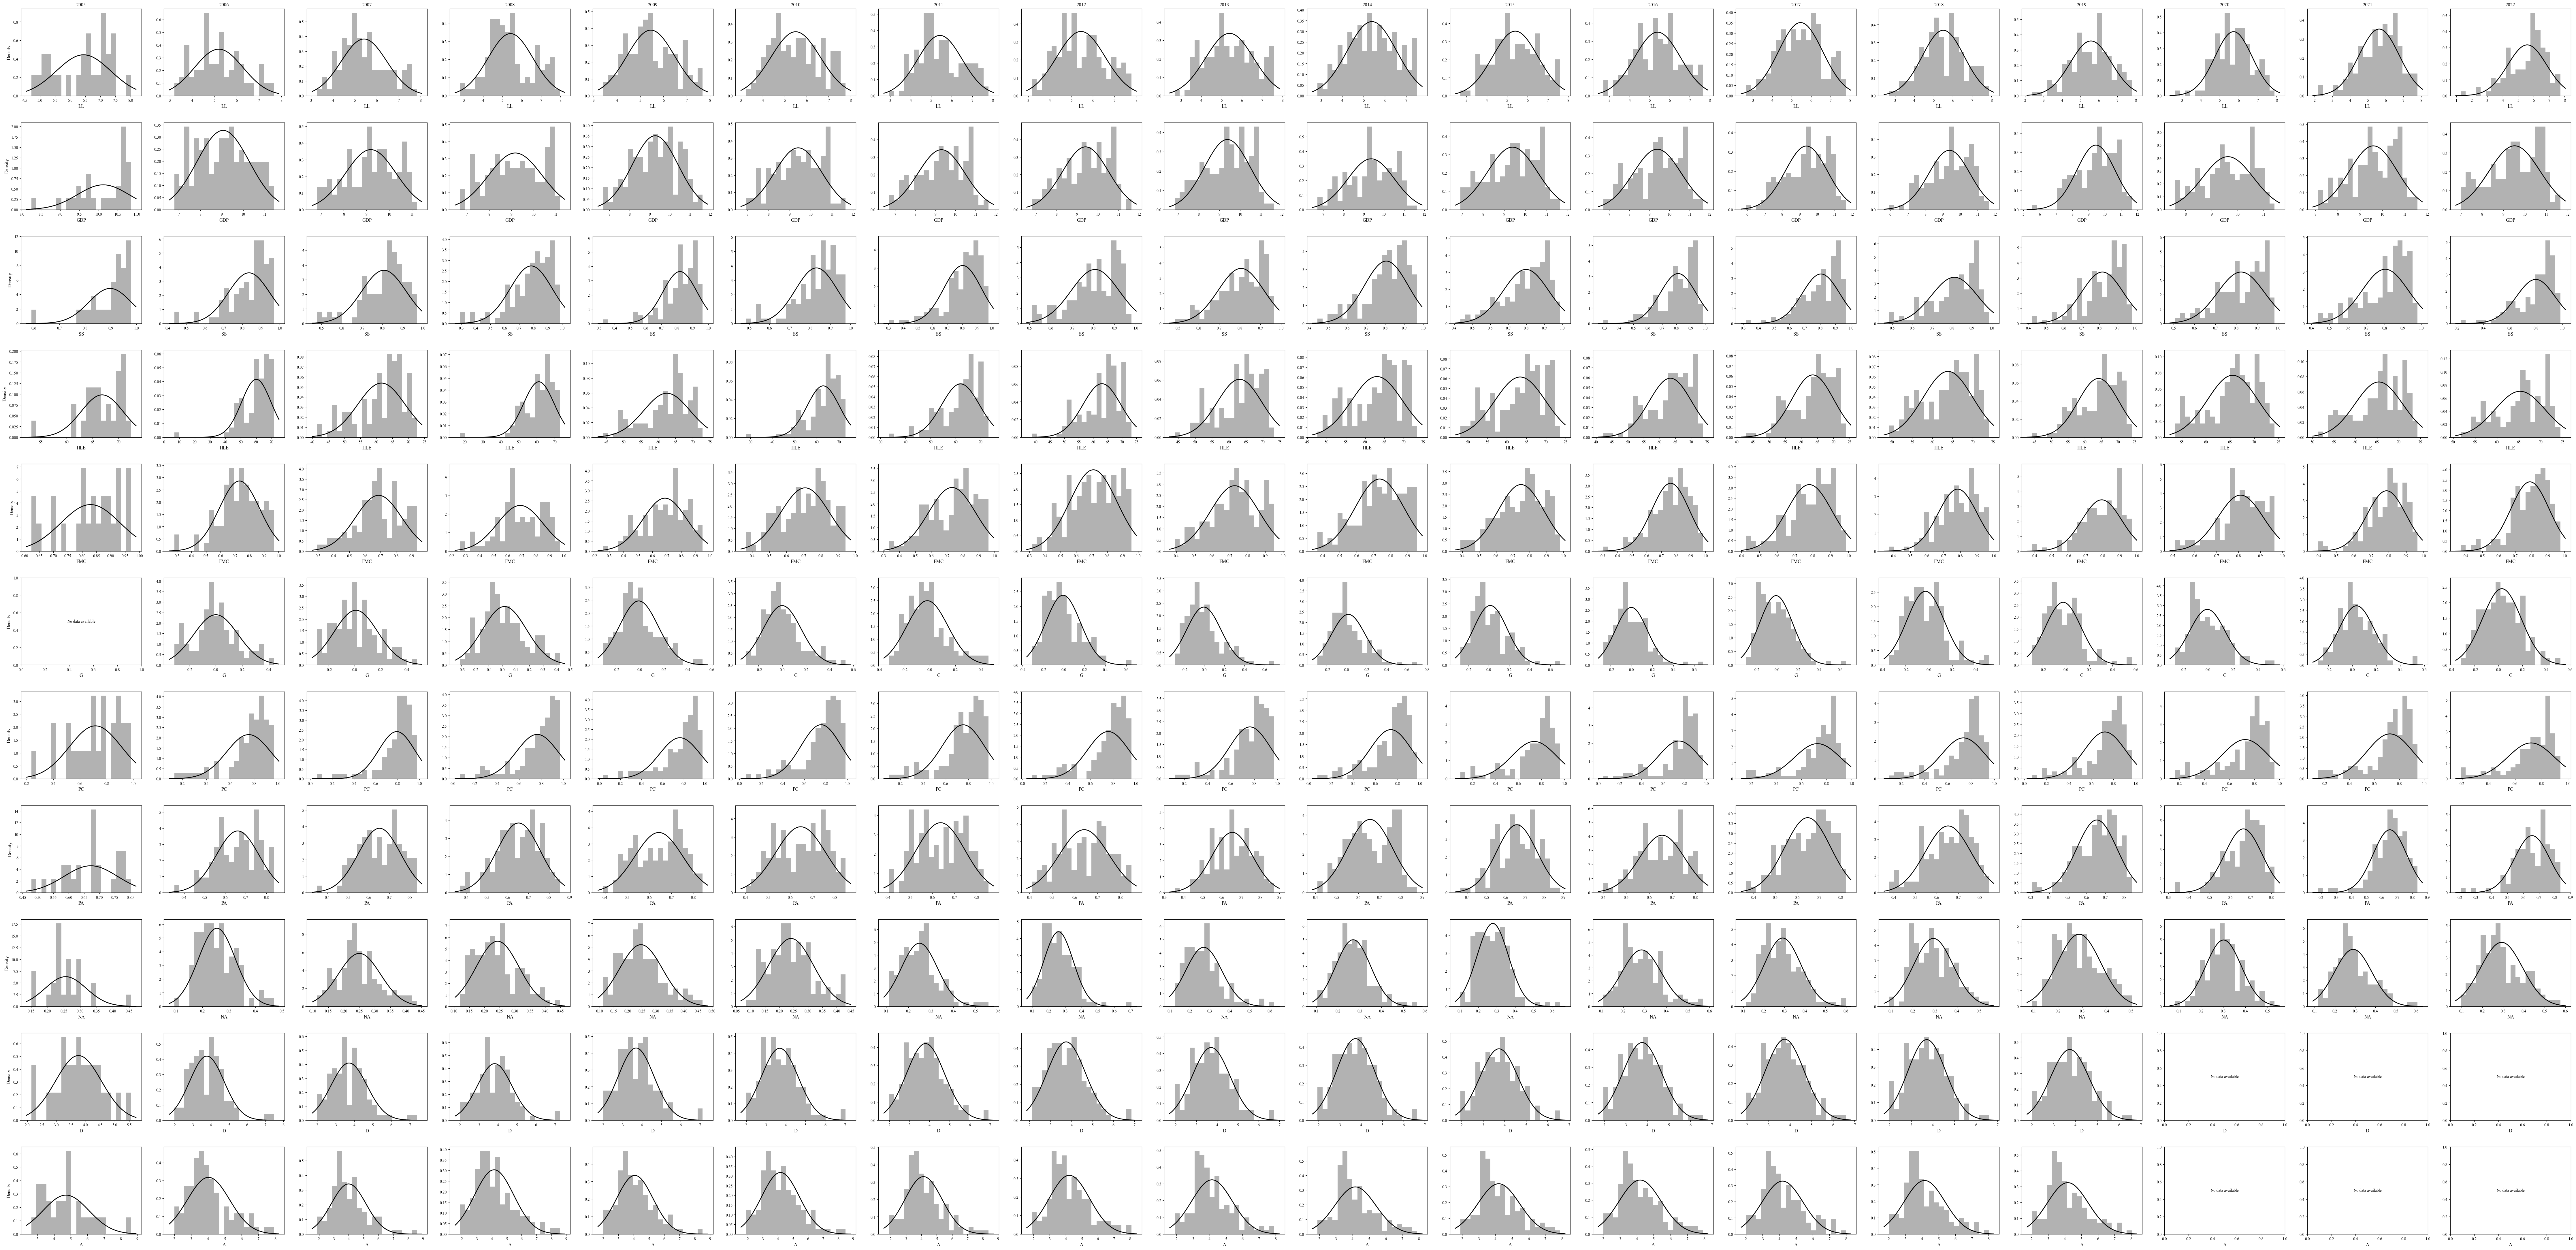

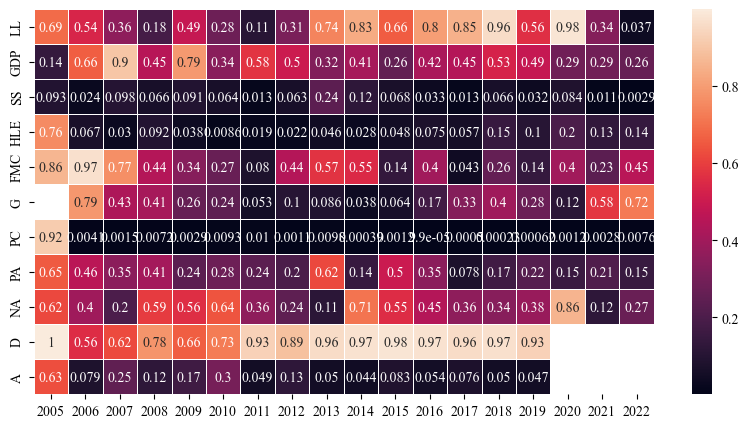

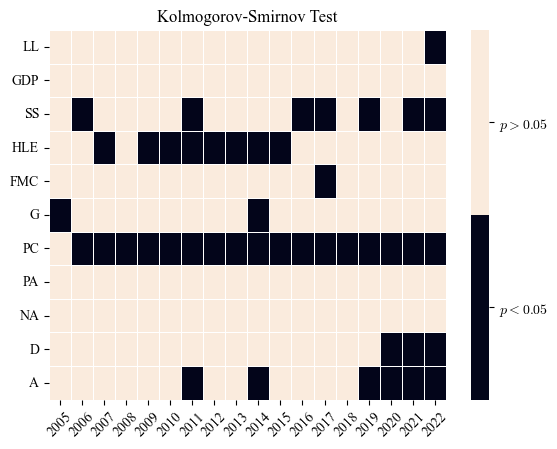

In [11]:
def plot_yearly_histograms(df_full, save = False):
    """
    Plot yearly histograms for numeric variables in the DataFrame. Rows represent variables and columns represent years.
    Plot the p-value matrix for the Kolmogorov-Smirnov test for normality.

    Args:
        df_full (pandas.DataFrame): The DataFrame containing data.
        save (bool, optional): Whether to save the plots. Defaults to False.
        
    Returns:
        None
    """
    years = df_full['Year'].unique(); years.sort()
    numeric_vars = df_full.columns.drop(['Country', 'Year']).to_list() # Exclude Country and Year columns
    num_years = len(years); num_variables = len(numeric_vars)
    
    p_values_matrix = np.zeros((num_variables, num_years)) # Initialize p-value matrix
    
    # Adjust for single variable or single year cases
    fig, axs = plt.subplots(nrows=num_variables, ncols=num_years, figsize=(5 * num_years, 4 * num_variables))
    if num_variables == 1 or num_years == 1: axs = np.array(axs).reshape(num_variables, -1)  # Ensure axs is always a 2D array
    
    for j, var in enumerate(numeric_vars):  
        axs[j, 0].set_ylabel('Density')
        for i, year in enumerate(years):  
            axs[0,i].set_title(f'{year}')
            ax = axs[j, i] if num_variables > 1 and num_years > 1 else axs[max(j, i)]
            
            df_year = df_full[df_full['Year'] == year]
            
            if df_year[var].isna().all():
                ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_xlabel(f'{var}')
                p_values_matrix[j, i] = np.nan
                continue
            
            clean_data = df_year[var].dropna()
            mu, std = norm.fit(clean_data)
            
            if np.isclose(std, 0):
                ax.text(0.5, 0.5, 'Variance too low', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                p_values_matrix[j, i] = np.nan
                continue

            D, p_value = kstest(clean_data, 'norm', args=(mu, std)) # Kolmogorov-Smirnov test
            p_values_matrix[j, i] = p_value
            
            ax.hist(clean_data, bins=20, density=True, alpha=0.6, color='gray')
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            ax.plot(x, p, 'k', linewidth=2)
            ax.set_xlabel(f'{var}')
        
    
    plt.tight_layout(pad=3.0)
    if save: plt.savefig('Figures/Histograms_per_year_and_variable.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(p_values_matrix, annot=True, xticklabels = years, yticklabels=numeric_vars, linewidths=0.7)
    plt.show()
    
    p_values_matrix[p_values_matrix > 0.05] = 1
    p_values_matrix[p_values_matrix != 1] = 0

    default_cmap = plt.get_cmap('rocket')
    colors = [default_cmap(0.0), default_cmap(1.0)] 
    cmap = LinearSegmentedColormap.from_list("Custom", colors, N=2)
    
    fig, ax = plt.subplots()
    sns.heatmap(p_values_matrix, annot=False, xticklabels = years, yticklabels=numeric_vars, cmap=cmap, linewidths=0.7, ax=ax)
    ax.set_title("Kolmogorov-Smirnov Test")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Customize the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels([r'$p < 0.05$', r'$p > 0.05$'])
    if save: plt.savefig("Figures/KS_tests_binary_p-value_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_yearly_histograms(df_full, save = False)

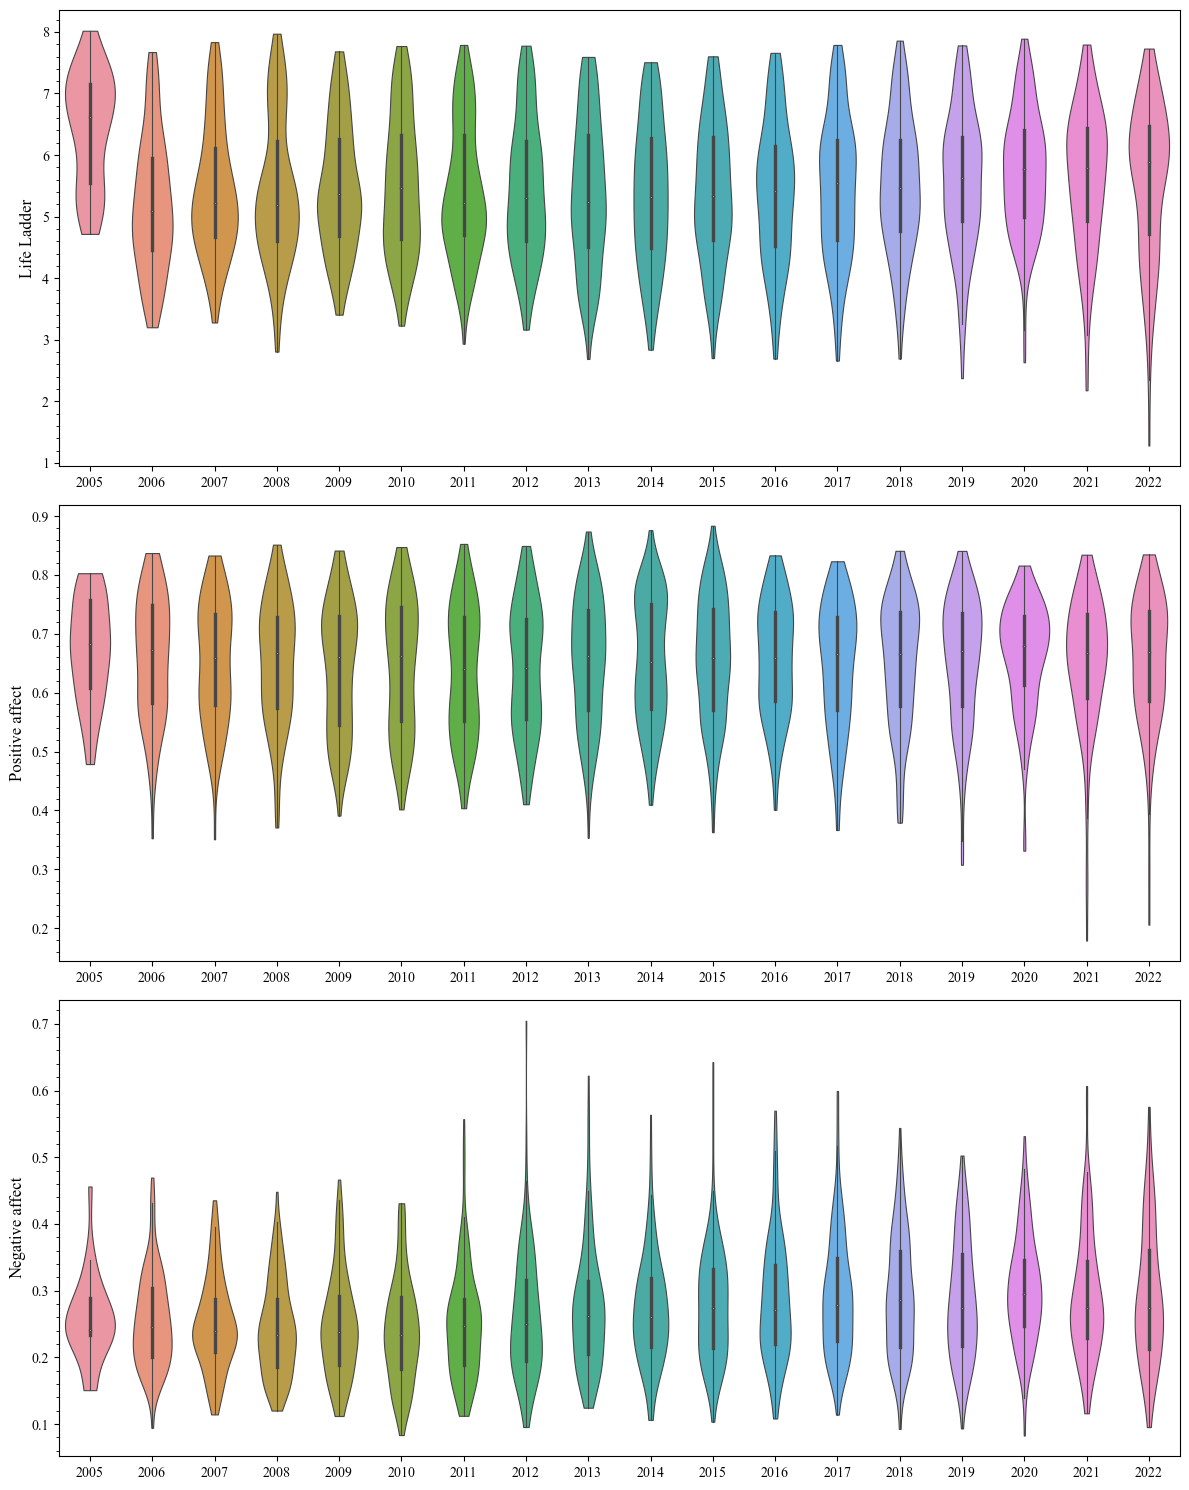

In [13]:
def plot_violin_plots_by_year(df_full, variables, save = False, filename = "Violin_plots_per_year_and_variable.png"):
    """
    Plot violin plots for specified variables across different years.

    Args:
        df_full (pandas.DataFrame): The DataFrame containing data.
        variables (list): List of variables for which violin plots will be created.
        save (bool, optional): Whether to save the plot. Defaults to False.
        filename (str, optional): Name of the file to save the plot. Defaults to "Violin_plots_per_year_and_variable.png".
        
    Returns:
        None
    """
    # Determine unique years and sort them
    years = sorted(df_full['Year'].unique())
    
    # Create a figure with subplots - one row per variable
    num_vars = len(variables)
    fig, axs = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 5 * num_vars), squeeze=False)
    
    for i, var in enumerate(variables):
        # Track which years have data for the current variable
        years_with_data = []
        data_to_plot = []
        for year in years:
            # Filter data for the year and variable, drop NA to avoid plotting issues
            yearly_data = df_full[df_full['Year'] == year][var].dropna()
            if not yearly_data.empty:
                years_with_data.append(year)  # Only add years that have data
                data_to_plot.append(yearly_data)
        
        # Check if there's data to plot
        if data_to_plot:
            # Plot violin plot for the current variable across all years
            sns.violinplot(data=data_to_plot, ax=axs[i, 0], cut=0)
            # Set x-tick labels to years that have data
            axs[i, 0].set_xticklabels(years_with_data)
            # Add autominor locators to the x-axis
            axs[i, 0].yaxis.set_minor_locator(AutoMinorLocator())
            axs[i, 0].set_ylabel(acronyms_mapping[var])
    
    plt.tight_layout()
    if save: plt.savefig(filename, dpi=300)
    plt.show()

WB_vars = ['LL', 'PA', 'NA']
# plot_violin_plots_by_year(df_full, variables[0:5], save = False, filename = "Violin_plots_per_year_and_variable_1.png")
# plot_violin_plots_by_year(df_full, variables[5:], save = False, filename = "Violin_plots_per_year_and_variable_2.png")
# plot_violin_plots_by_year(df_full, WB_vars, save = False, filename = "Figures/Violin_plots_per_year_and_variable_3.png")

# 1. Pairwise Dependencies

LL vs GDP:
-------------------------------------------------
Pearson correlation: 0.74, p-value: 2.6561715914294293e-26
Spearman correlation: 0.78, p-value: 1.9242701891668264e-30
Kendall correlation: 0.58, p-value: 5.313305288109545e-25
Mutual information: 0.61, p-value: 0.00e+00
-------------------------------------------------


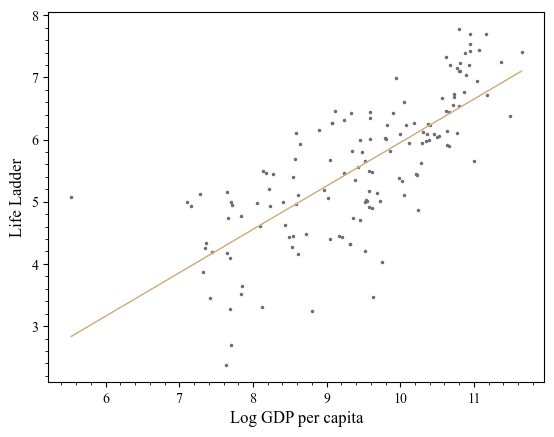

LL vs SS:
-------------------------------------------------
Pearson correlation: 0.73, p-value: 4.963032473712655e-25
Spearman correlation: 0.76, p-value: 2.0557975703658258e-28
Kendall correlation: 0.56, p-value: 4.407878828876405e-23
Mutual information: 0.39, p-value: 0.00e+00
-------------------------------------------------


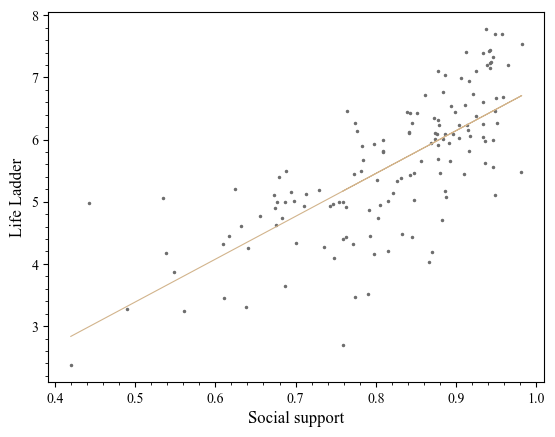

LL vs HLE:
-------------------------------------------------
Pearson correlation: 0.75, p-value: 1.989058109281756e-26
Spearman correlation: 0.75, p-value: 8.074030668740089e-27
Kendall correlation: 0.56, p-value: 3.569792056214092e-22
Mutual information: 0.45, p-value: 0.00e+00
-------------------------------------------------


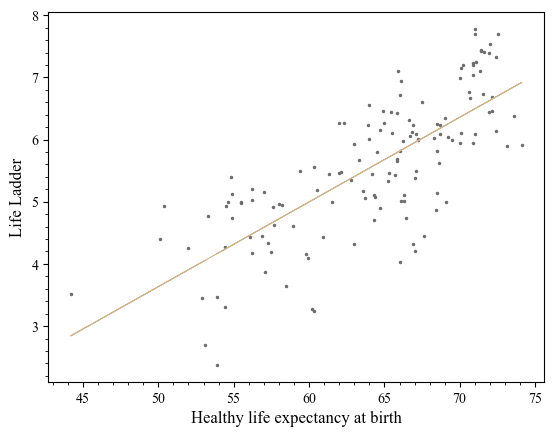

LL vs FMC:
-------------------------------------------------
Pearson correlation: 0.59, p-value: 2.034384491919538e-14
Spearman correlation: 0.62, p-value: 2.489327520123556e-16
Kendall correlation: 0.44, p-value: 4.032417496200923e-15
Mutual information: 0.26, p-value: 0.00e+00
-------------------------------------------------


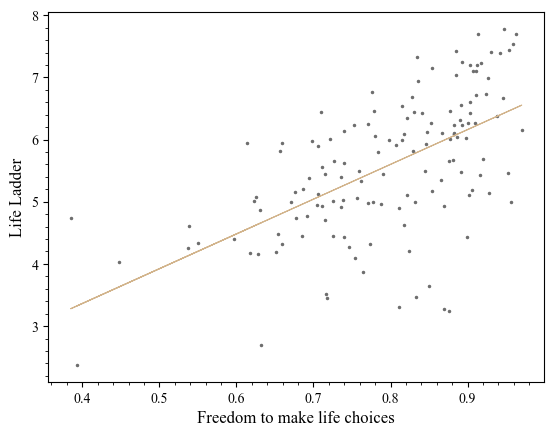

LL vs G:
-------------------------------------------------
Pearson correlation: 0.02, p-value: 0.7951912018481158
Spearman correlation: 0.02, p-value: 0.7876962772128842
Kendall correlation: 0.01, p-value: 0.8447865082889481
Mutual information: 0.21, p-value: 0.00e+00
-------------------------------------------------


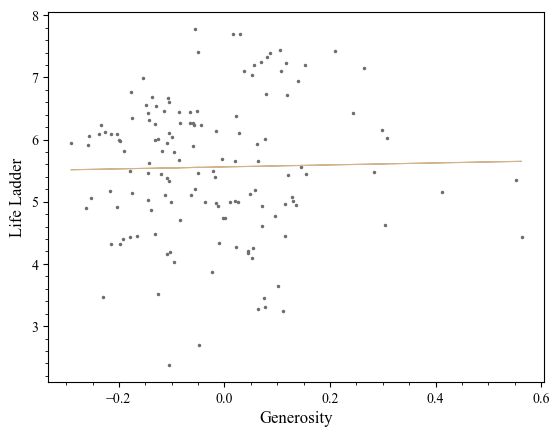

LL vs PC:
-------------------------------------------------
Pearson correlation: -0.43, p-value: 2.629408203200674e-07
Spearman correlation: -0.33, p-value: 9.067757399297977e-05
Kendall correlation: -0.23, p-value: 9.269008901777806e-05
Mutual information: 0.26, p-value: 0.00e+00
-------------------------------------------------


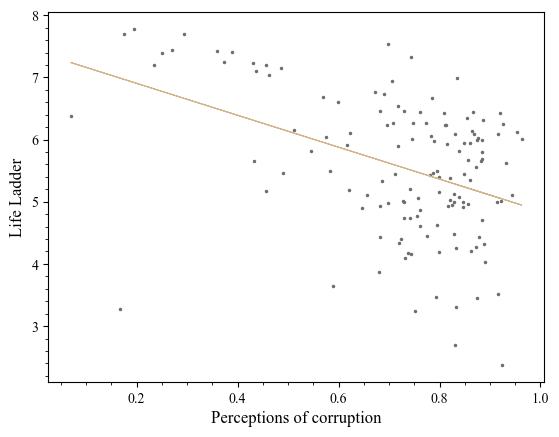

LL vs PA:
-------------------------------------------------
Pearson correlation: 0.47, p-value: 3.770305859558421e-09
Spearman correlation: 0.49, p-value: 9.373589992011e-10
Kendall correlation: 0.33, p-value: 7.639034092458276e-09
Mutual information: 0.15, p-value: 8.00e-03
-------------------------------------------------


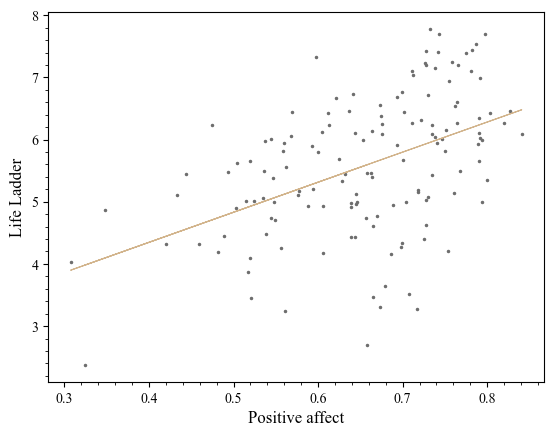

LL vs NA:
-------------------------------------------------
Pearson correlation: -0.50, p-value: 3.6102012645719487e-10
Spearman correlation: -0.48, p-value: 2.048199708570126e-09
Kendall correlation: -0.33, p-value: 8.481524661651665e-09
Mutual information: 0.31, p-value: 0.00e+00
-------------------------------------------------


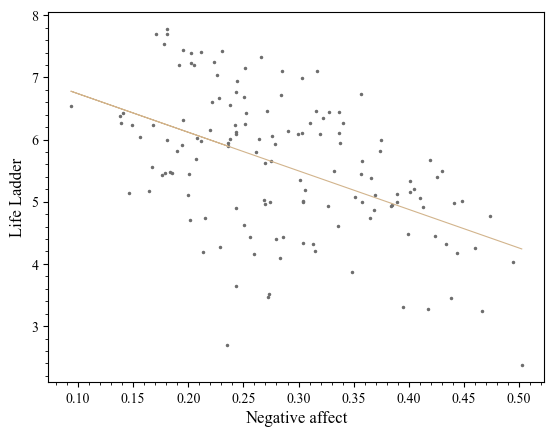

LL vs D:
-------------------------------------------------
Pearson correlation: -0.36, p-value: 1.3169476508191636e-05
Spearman correlation: -0.38, p-value: 3.1164699645453033e-06
Kendall correlation: -0.23, p-value: 4.3233830341821414e-05
Mutual information: 0.17, p-value: 6.00e-03
-------------------------------------------------


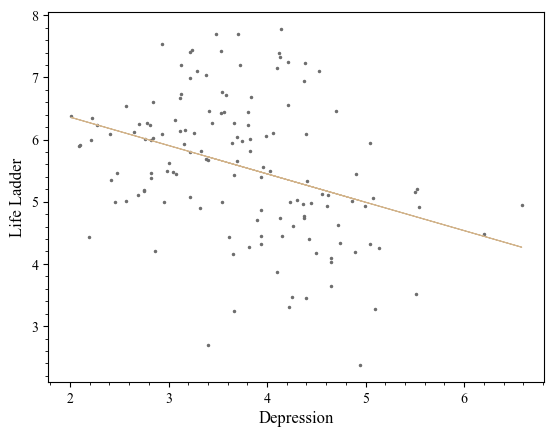

LL vs A:
-------------------------------------------------
Pearson correlation: 0.37, p-value: 5.708701804953108e-06
Spearman correlation: 0.37, p-value: 6.3228028346829395e-06
Kendall correlation: 0.24, p-value: 3.3141106863388256e-05
Mutual information: 0.16, p-value: 2.00e-03
-------------------------------------------------


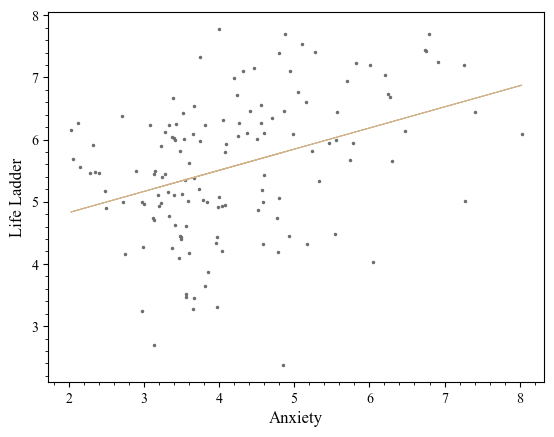

GDP vs SS:
-------------------------------------------------
Pearson correlation: 0.69, p-value: 7.84291491606272e-22
Spearman correlation: 0.76, p-value: 7.664954733293608e-28
Kendall correlation: 0.56, p-value: 3.574679254843363e-23
Mutual information: 0.38, p-value: 0.00e+00
-------------------------------------------------


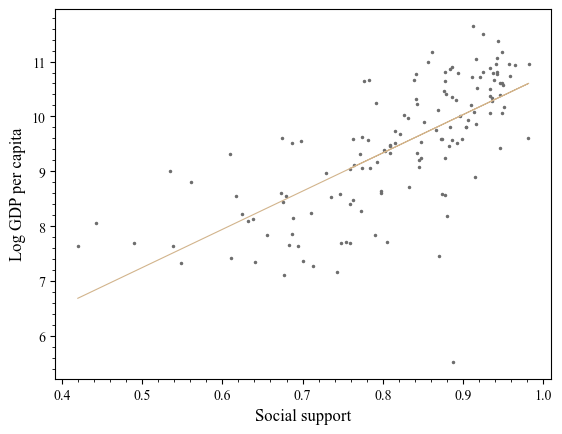

GDP vs HLE:
-------------------------------------------------
Pearson correlation: 0.81, p-value: 3.2886127784523974e-34
Spearman correlation: 0.85, p-value: 5.012545928931257e-40
Kendall correlation: 0.66, p-value: 1.0655612998272886e-30
Mutual information: 0.68, p-value: 0.00e+00
-------------------------------------------------


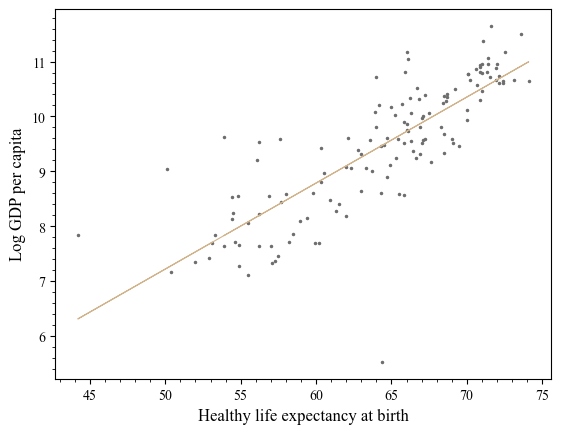

GDP vs FMC:
-------------------------------------------------
Pearson correlation: 0.43, p-value: 6.48631756474563e-08
Spearman correlation: 0.45, p-value: 1.8357496744466214e-08
Kendall correlation: 0.31, p-value: 3.0265293217069826e-08
Mutual information: 0.08, p-value: 7.70e-02
-------------------------------------------------


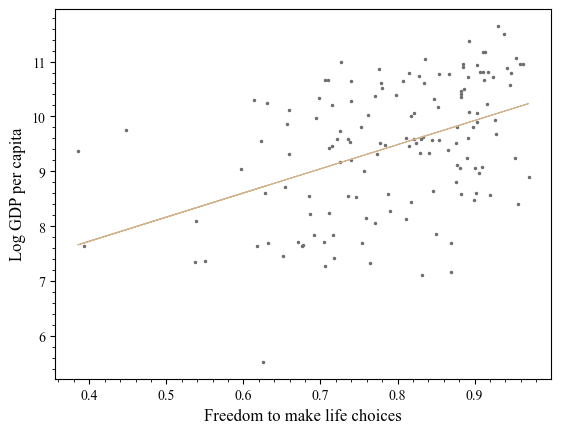

GDP vs G:
-------------------------------------------------
Pearson correlation: -0.20, p-value: 0.019983259484796075
Spearman correlation: -0.16, p-value: 0.05627282356740305
Kendall correlation: -0.12, p-value: 0.039563260829488515
Mutual information: 0.19, p-value: 3.00e-03
-------------------------------------------------


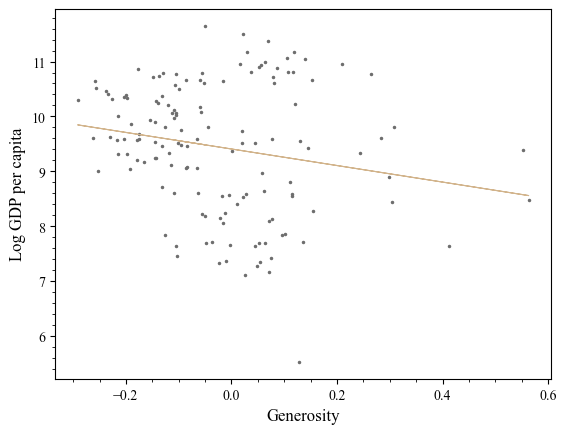

GDP vs PC:
-------------------------------------------------
Pearson correlation: -0.35, p-value: 3.0221172304821026e-05
Spearman correlation: -0.28, p-value: 0.001059155703698993
Kendall correlation: -0.18, p-value: 0.0019192692872588653
Mutual information: 0.26, p-value: 0.00e+00
-------------------------------------------------


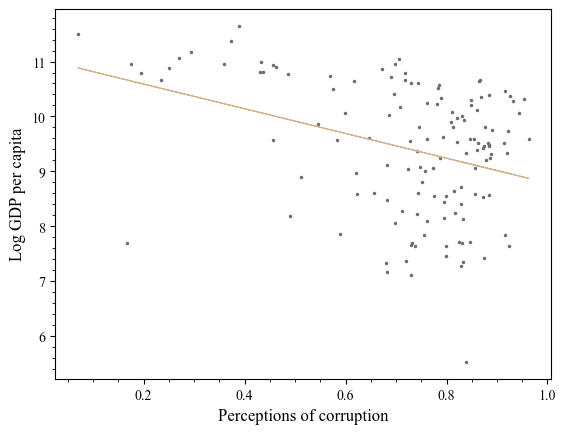

GDP vs PA:
-------------------------------------------------
Pearson correlation: 0.18, p-value: 0.03000790547912253
Spearman correlation: 0.22, p-value: 0.007856707257038109
Kendall correlation: 0.15, p-value: 0.007861748725712752
Mutual information: 0.08, p-value: 1.00e-01
-------------------------------------------------


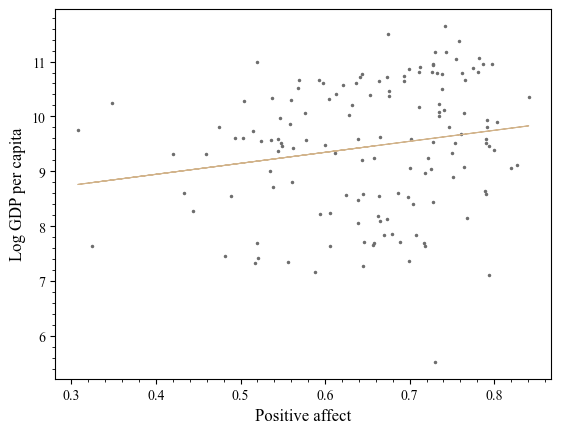

GDP vs NA:
-------------------------------------------------
Pearson correlation: -0.51, p-value: 1.1588609860949742e-10
Spearman correlation: -0.51, p-value: 1.1164921134898711e-10
Kendall correlation: -0.35, p-value: 1.0325825265295183e-09
Mutual information: 0.02, p-value: 3.08e-01
-------------------------------------------------


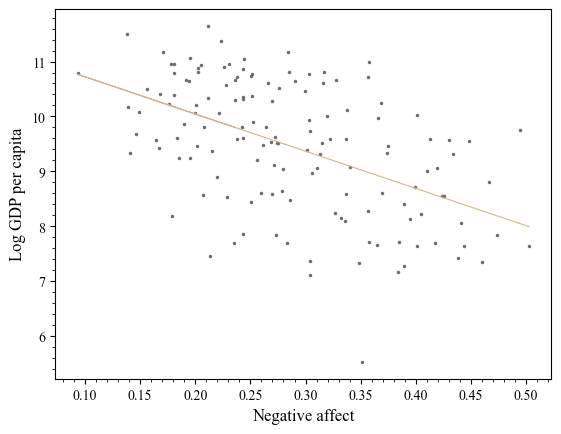

GDP vs D:
-------------------------------------------------
Pearson correlation: -0.40, p-value: 1.330208741017231e-06
Spearman correlation: -0.37, p-value: 8.89727852541632e-06
Kendall correlation: -0.24, p-value: 2.655312085469e-05
Mutual information: 0.07, p-value: 1.20e-01
-------------------------------------------------


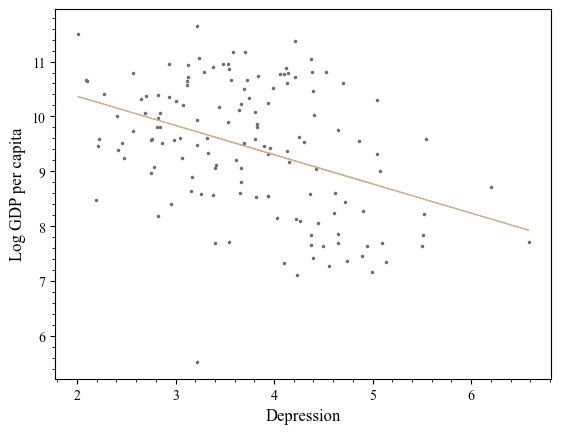

GDP vs A:
-------------------------------------------------
Pearson correlation: 0.39, p-value: 1.608302384411442e-06
Spearman correlation: 0.40, p-value: 1.1212111985074637e-06
Kendall correlation: 0.26, p-value: 3.7871225886249065e-06
Mutual information: 0.16, p-value: 5.00e-03
-------------------------------------------------


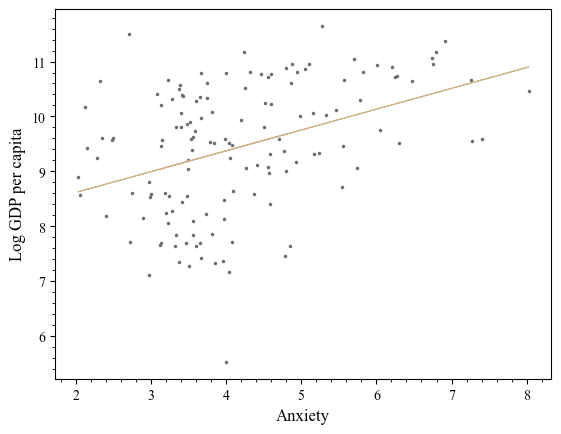

SS vs HLE:
-------------------------------------------------
Pearson correlation: 0.65, p-value: 3.059895700322694e-18
Spearman correlation: 0.68, p-value: 1.7443691525688125e-20
Kendall correlation: 0.49, p-value: 1.155261285363112e-17
Mutual information: 0.33, p-value: 0.00e+00
-------------------------------------------------


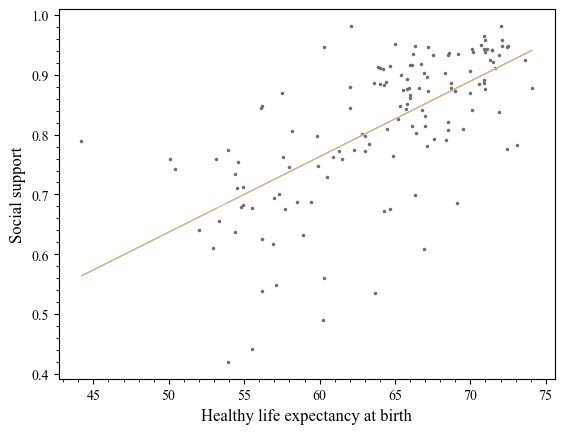

SS vs FMC:
-------------------------------------------------
Pearson correlation: 0.43, p-value: 1.3435804131762228e-07
Spearman correlation: 0.46, p-value: 8.82703260214842e-09
Kendall correlation: 0.31, p-value: 3.483780653944507e-08
Mutual information: 0.10, p-value: 4.80e-02
-------------------------------------------------


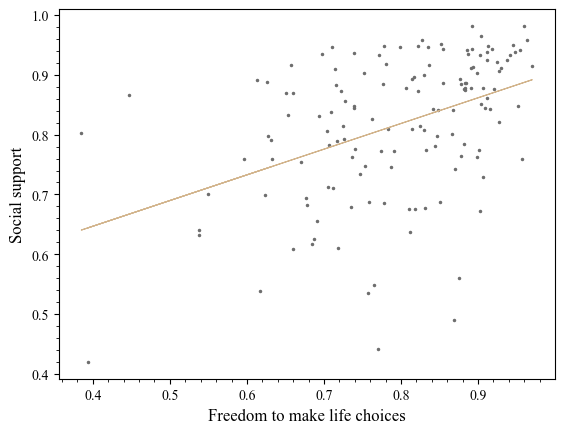

SS vs G:
-------------------------------------------------
Pearson correlation: -0.07, p-value: 0.39553817446687134
Spearman correlation: -0.06, p-value: 0.48553474095862503
Kendall correlation: -0.05, p-value: 0.40613199457709703
Mutual information: 0.08, p-value: 7.50e-02
-------------------------------------------------


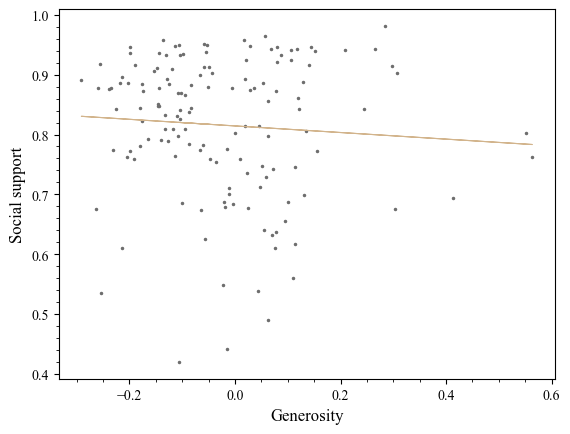

SS vs PC:
-------------------------------------------------
Pearson correlation: -0.22, p-value: 0.010668453712698792
Spearman correlation: -0.20, p-value: 0.022613263984306624
Kendall correlation: -0.12, p-value: 0.04162698468879216
Mutual information: 0.14, p-value: 1.50e-02
-------------------------------------------------


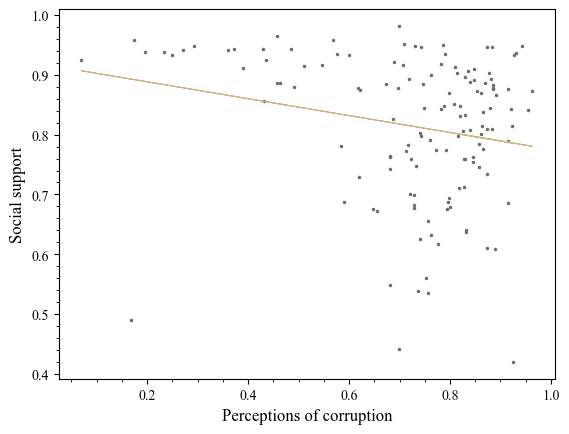

SS vs PA:
-------------------------------------------------
Pearson correlation: 0.31, p-value: 0.00016218836206764232
Spearman correlation: 0.29, p-value: 0.00041523500224595675
Kendall correlation: 0.20, p-value: 0.0004951272783801256
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


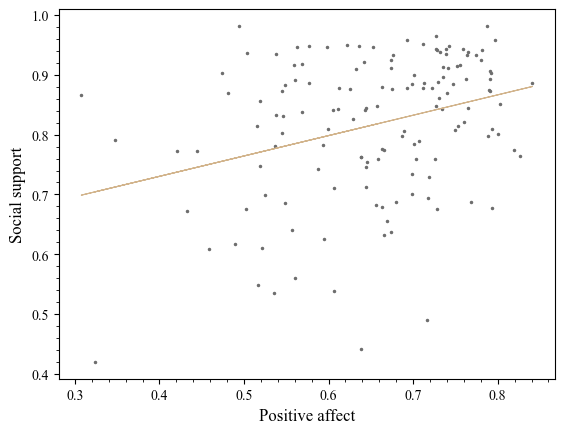

SS vs NA:
-------------------------------------------------
Pearson correlation: -0.69, p-value: 1.4362419262095314e-21
Spearman correlation: -0.68, p-value: 1.0958037420540422e-20
Kendall correlation: -0.49, p-value: 7.851586949281813e-18
Mutual information: 0.30, p-value: 0.00e+00
-------------------------------------------------


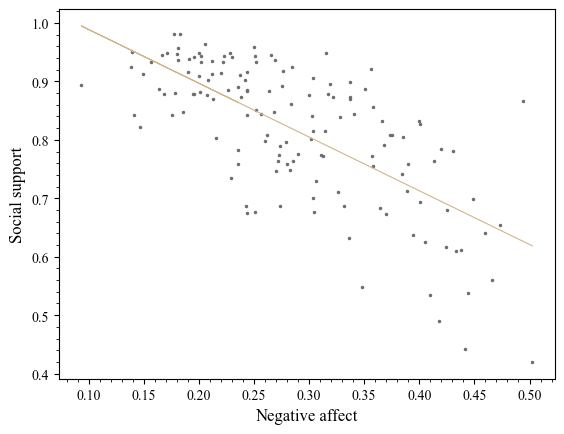

SS vs D:
-------------------------------------------------
Pearson correlation: -0.42, p-value: 3.4292832110446247e-07
Spearman correlation: -0.39, p-value: 1.7159077472976565e-06
Kendall correlation: -0.25, p-value: 9.991338575015371e-06
Mutual information: 0.18, p-value: 0.00e+00
-------------------------------------------------


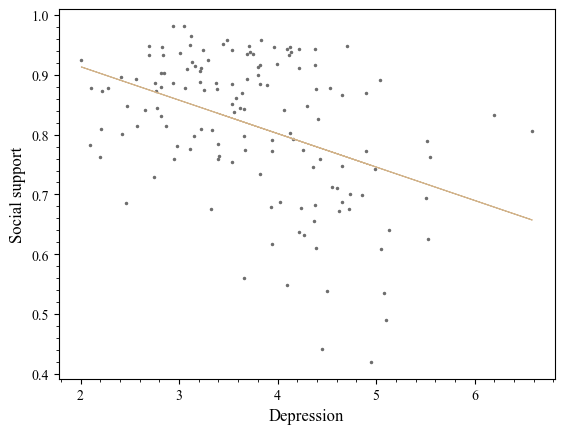

SS vs A:
-------------------------------------------------
Pearson correlation: 0.22, p-value: 0.00800857293112727
Spearman correlation: 0.23, p-value: 0.005599084012489568
Kendall correlation: 0.17, p-value: 0.0038126164066965918
Mutual information: 0.07, p-value: 1.18e-01
-------------------------------------------------


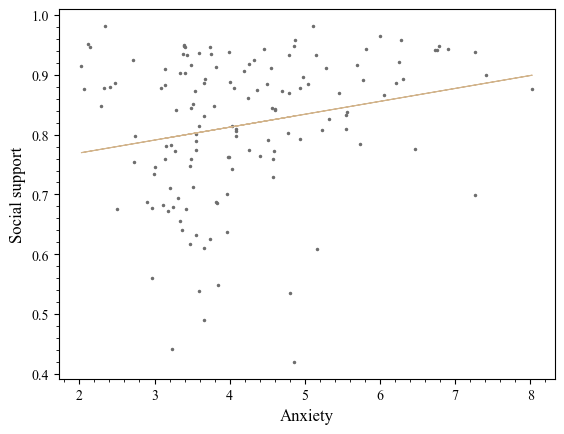

HLE vs FMC:
-------------------------------------------------
Pearson correlation: 0.42, p-value: 2.8791223794806053e-07
Spearman correlation: 0.42, p-value: 2.509037575397645e-07
Kendall correlation: 0.29, p-value: 3.0350804246179176e-07
Mutual information: 0.07, p-value: 1.10e-01
-------------------------------------------------


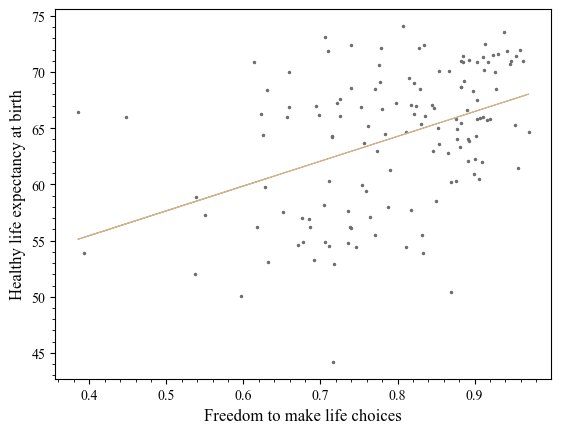

HLE vs G:
-------------------------------------------------
Pearson correlation: -0.14, p-value: 0.10039901509454331
Spearman correlation: -0.15, p-value: 0.085528591734974
Kendall correlation: -0.10, p-value: 0.08521430124188623
Mutual information: 0.18, p-value: 3.00e-03
-------------------------------------------------


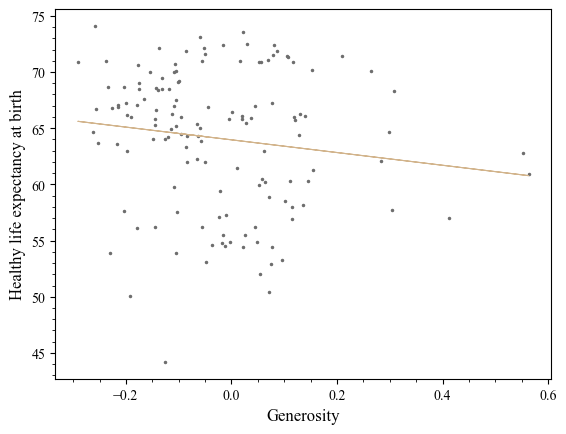

HLE vs PC:
-------------------------------------------------
Pearson correlation: -0.33, p-value: 0.00010394913894838516
Spearman correlation: -0.22, p-value: 0.009789854199913368
Kendall correlation: -0.15, p-value: 0.01331207803606701
Mutual information: 0.19, p-value: 1.00e-03
-------------------------------------------------


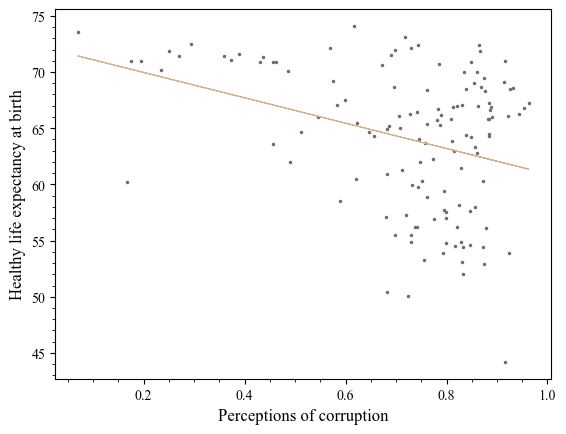

HLE vs PA:
-------------------------------------------------
Pearson correlation: 0.17, p-value: 0.04306705700699359
Spearman correlation: 0.22, p-value: 0.010590688415125145
Kendall correlation: 0.14, p-value: 0.015806045382078287
Mutual information: 0.05, p-value: 2.05e-01
-------------------------------------------------


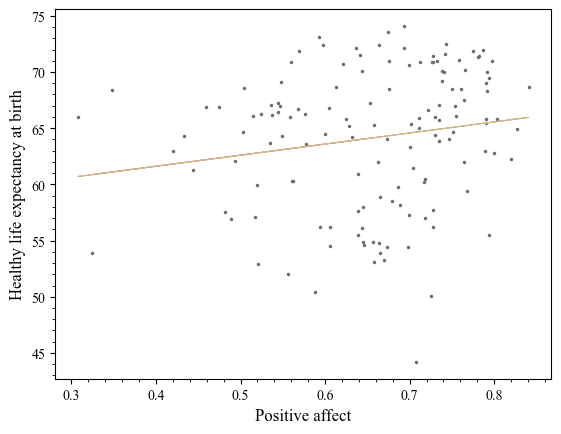

HLE vs NA:
-------------------------------------------------
Pearson correlation: -0.44, p-value: 5.814185807977562e-08
Spearman correlation: -0.43, p-value: 1.7782940440100393e-07
Kendall correlation: -0.29, p-value: 3.9456561859438775e-07
Mutual information: 0.03, p-value: 2.91e-01
-------------------------------------------------


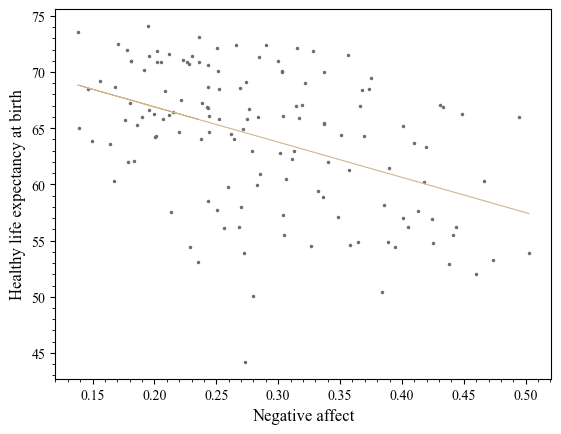

HLE vs D:
-------------------------------------------------
Pearson correlation: -0.49, p-value: 7.02132646445007e-10
Spearman correlation: -0.44, p-value: 5.281087759099396e-08
Kendall correlation: -0.29, p-value: 4.346286228646363e-07
Mutual information: 0.31, p-value: 0.00e+00
-------------------------------------------------


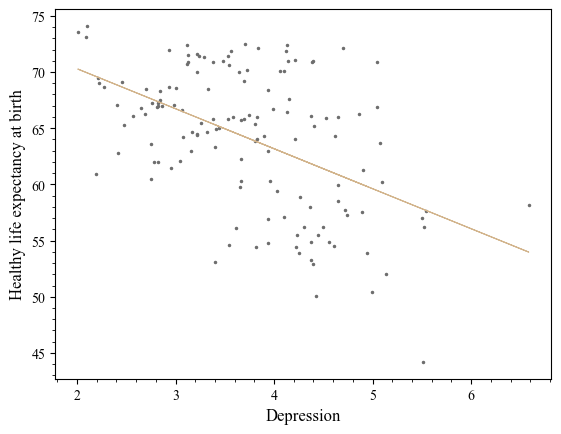

HLE vs A:
-------------------------------------------------
Pearson correlation: 0.43, p-value: 1.1018145204980317e-07
Spearman correlation: 0.45, p-value: 2.4480433714076112e-08
Kendall correlation: 0.31, p-value: 6.039838807302831e-08
Mutual information: 0.26, p-value: 0.00e+00
-------------------------------------------------


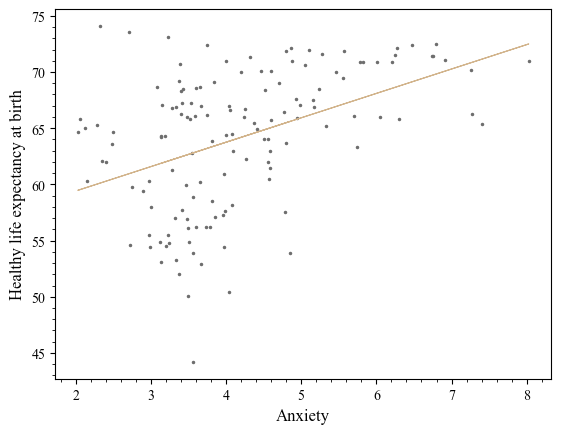

FMC vs G:
-------------------------------------------------
Pearson correlation: 0.15, p-value: 0.08282201978363306
Spearman correlation: 0.15, p-value: 0.06869847042873847
Kendall correlation: 0.09, p-value: 0.09666121361781933
Mutual information: 0.03, p-value: 3.19e-01
-------------------------------------------------


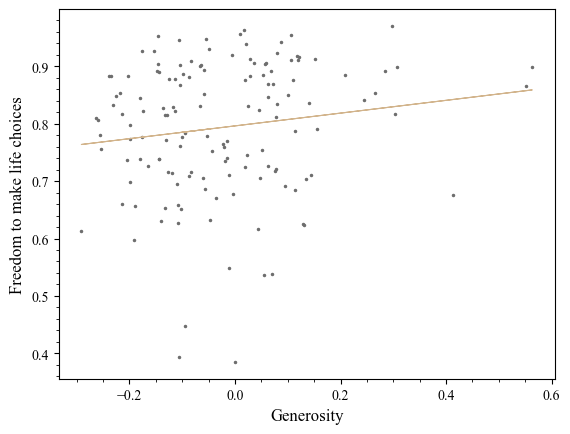

FMC vs PC:
-------------------------------------------------
Pearson correlation: -0.42, p-value: 4.6699960105354336e-07
Spearman correlation: -0.39, p-value: 2.626396244689032e-06
Kendall correlation: -0.27, p-value: 4.830989658003719e-06
Mutual information: 0.20, p-value: 0.00e+00
-------------------------------------------------


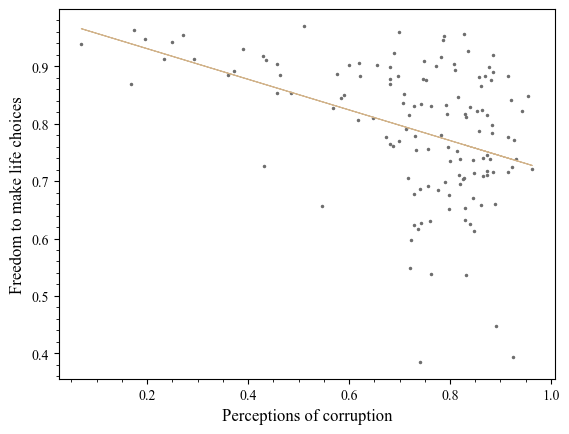

FMC vs PA:
-------------------------------------------------
Pearson correlation: 0.55, p-value: 9.252657844519565e-13
Spearman correlation: 0.55, p-value: 2.4658220111078668e-12
Kendall correlation: 0.37, p-value: 7.71741064929026e-11
Mutual information: 0.15, p-value: 6.00e-03
-------------------------------------------------


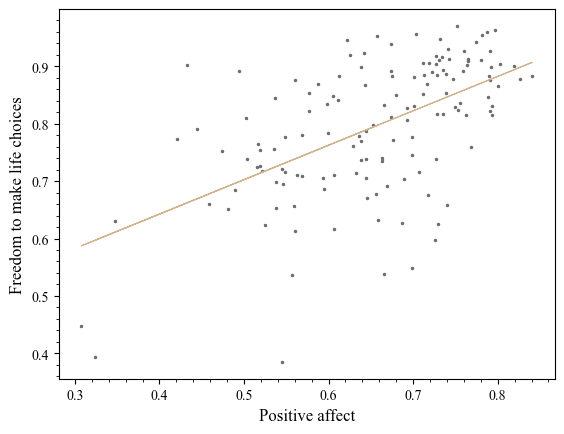

FMC vs NA:
-------------------------------------------------
Pearson correlation: -0.43, p-value: 7.138039418510465e-08
Spearman correlation: -0.43, p-value: 7.62010710335395e-08
Kendall correlation: -0.30, p-value: 8.748461060001733e-08
Mutual information: 0.11, p-value: 4.20e-02
-------------------------------------------------


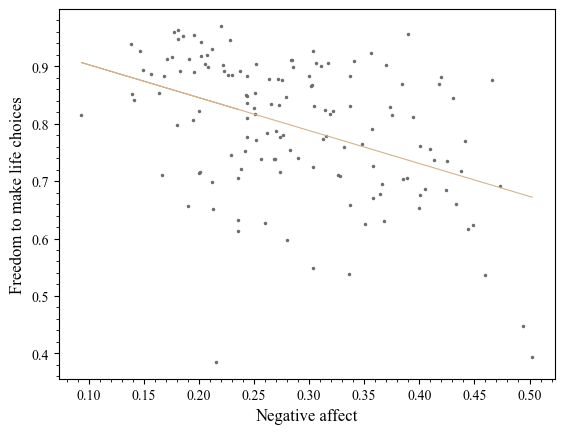

FMC vs D:
-------------------------------------------------
Pearson correlation: -0.41, p-value: 3.9090737608256555e-07
Spearman correlation: -0.40, p-value: 9.238819759309086e-07
Kendall correlation: -0.27, p-value: 3.221796496516227e-06
Mutual information: 0.11, p-value: 4.10e-02
-------------------------------------------------


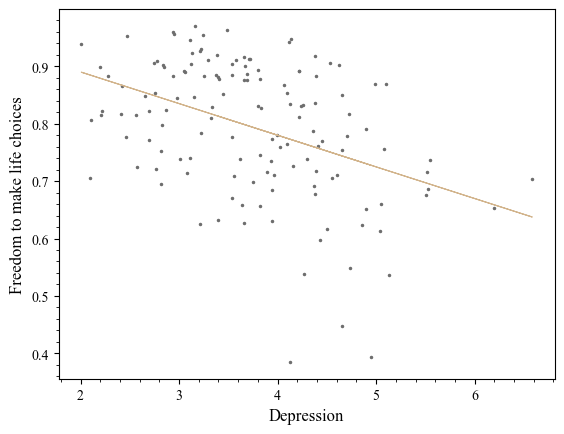

FMC vs A:
-------------------------------------------------
Pearson correlation: 0.09, p-value: 0.29440003315643815
Spearman correlation: 0.16, p-value: 0.05986645881367465
Kendall correlation: 0.11, p-value: 0.049861010131829336
Mutual information: 0.04, p-value: 1.97e-01
-------------------------------------------------


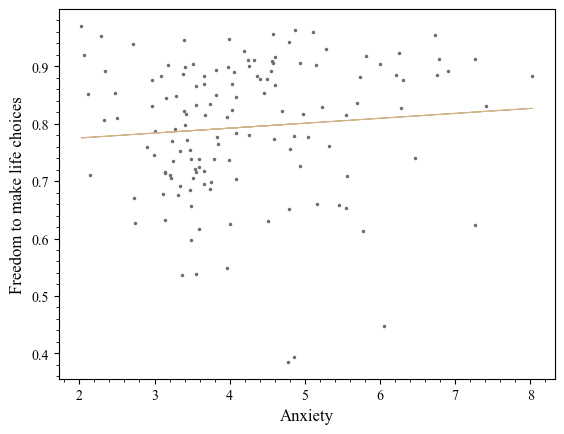

G vs PC:
-------------------------------------------------
Pearson correlation: -0.20, p-value: 0.020667951289879742
Spearman correlation: -0.24, p-value: 0.006100477829748139
Kendall correlation: -0.16, p-value: 0.006648384139184695
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


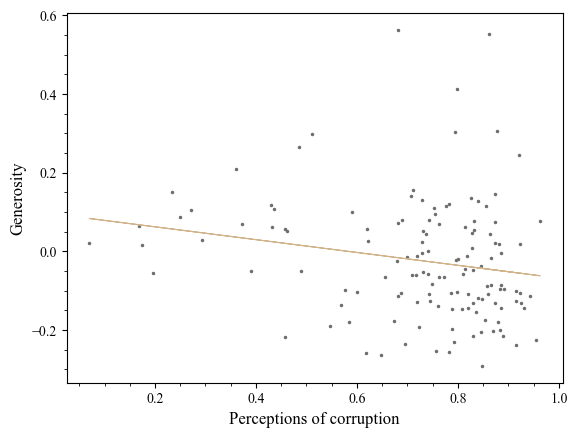

G vs PA:
-------------------------------------------------
Pearson correlation: 0.17, p-value: 0.043532978096982956
Spearman correlation: 0.15, p-value: 0.08225020281285753
Kendall correlation: 0.10, p-value: 0.0706964279610116
Mutual information: 0.09, p-value: 5.50e-02
-------------------------------------------------


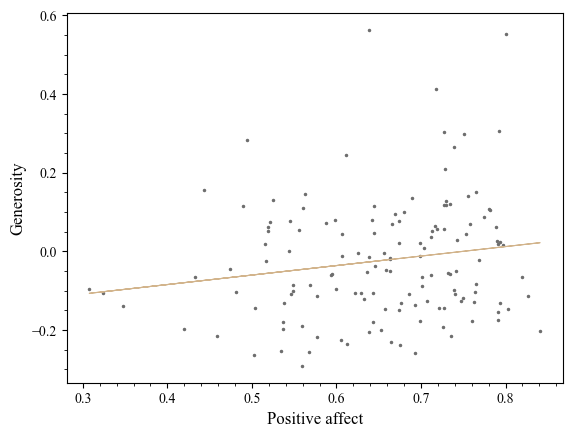

G vs NA:
-------------------------------------------------
Pearson correlation: 0.05, p-value: 0.54979259289334
Spearman correlation: 0.07, p-value: 0.3808162470812869
Kendall correlation: 0.05, p-value: 0.35398711079324985
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


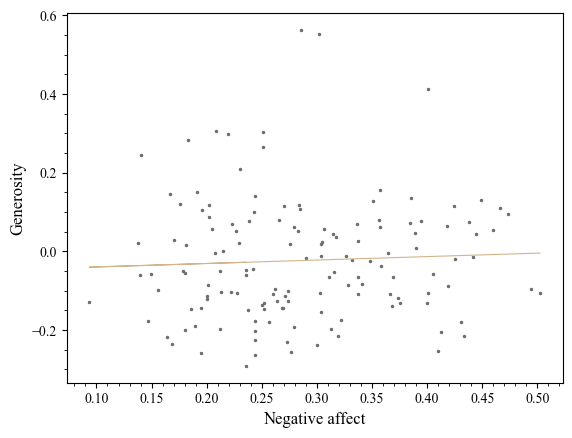

G vs D:
-------------------------------------------------
Pearson correlation: 0.06, p-value: 0.4760045593297392
Spearman correlation: 0.14, p-value: 0.09711428370345933
Kendall correlation: 0.10, p-value: 0.07950471959452418
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


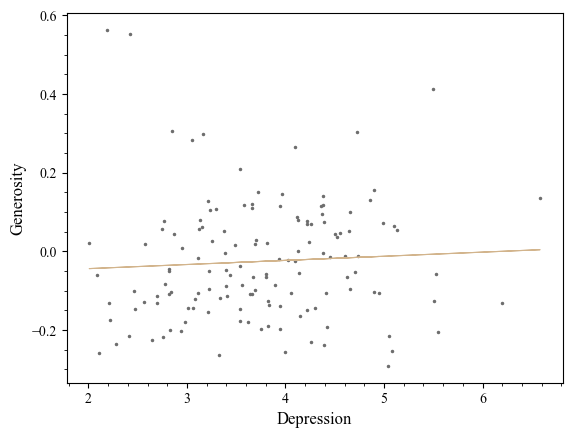

G vs A:
-------------------------------------------------
Pearson correlation: -0.02, p-value: 0.7981690254402697
Spearman correlation: -0.01, p-value: 0.9171709241775342
Kendall correlation: -0.00, p-value: 0.9665930336427436
Mutual information: 0.06, p-value: 1.49e-01
-------------------------------------------------


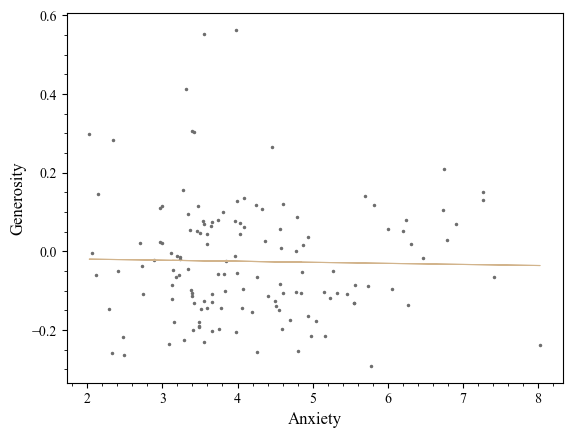

PC vs PA:
-------------------------------------------------
Pearson correlation: -0.27, p-value: 0.0016557727618595063
Spearman correlation: -0.22, p-value: 0.009581709712808372
Kendall correlation: -0.15, p-value: 0.009314931450836486
Mutual information: 0.10, p-value: 5.50e-02
-------------------------------------------------


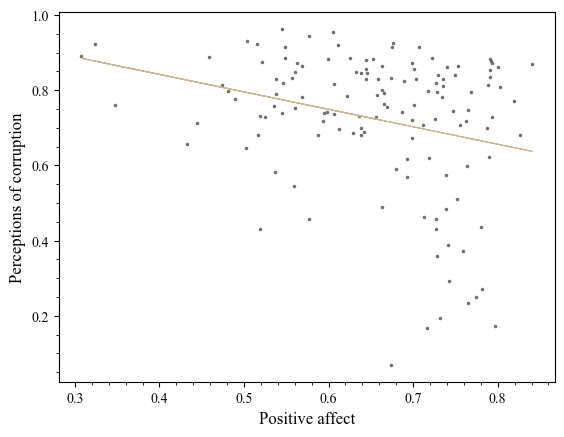

PC vs NA:
-------------------------------------------------
Pearson correlation: 0.28, p-value: 0.0008594963061914206
Spearman correlation: 0.20, p-value: 0.017478717681910304
Kendall correlation: 0.13, p-value: 0.021035924159170563
Mutual information: 0.05, p-value: 1.65e-01
-------------------------------------------------


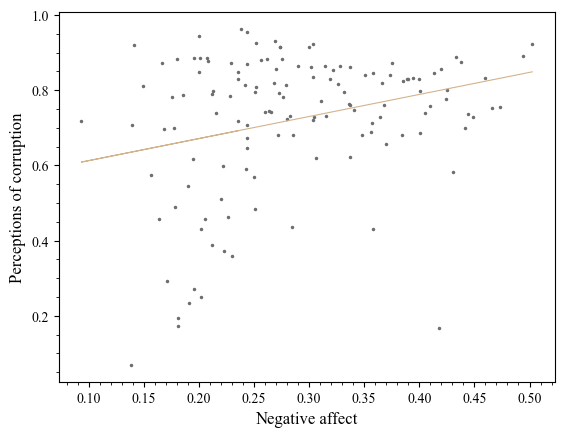

PC vs D:
-------------------------------------------------
Pearson correlation: 0.04, p-value: 0.6859870383882511
Spearman correlation: -0.06, p-value: 0.4943292848509686
Kendall correlation: -0.04, p-value: 0.4574678317357245
Mutual information: 0.13, p-value: 1.70e-02
-------------------------------------------------


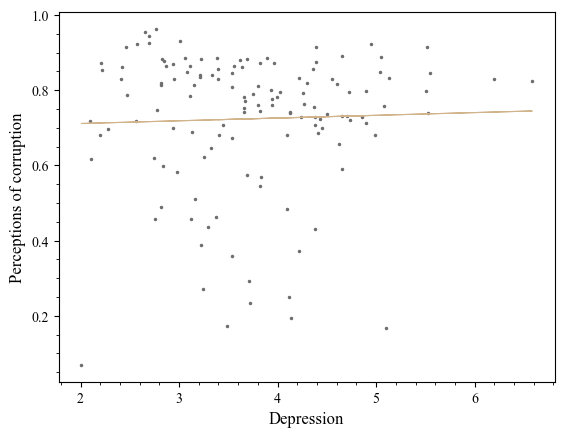

PC vs A:
-------------------------------------------------
Pearson correlation: -0.21, p-value: 0.017469666602555833
Spearman correlation: -0.11, p-value: 0.22783070682808684
Kendall correlation: -0.07, p-value: 0.2431895178478406
Mutual information: 0.08, p-value: 8.60e-02
-------------------------------------------------


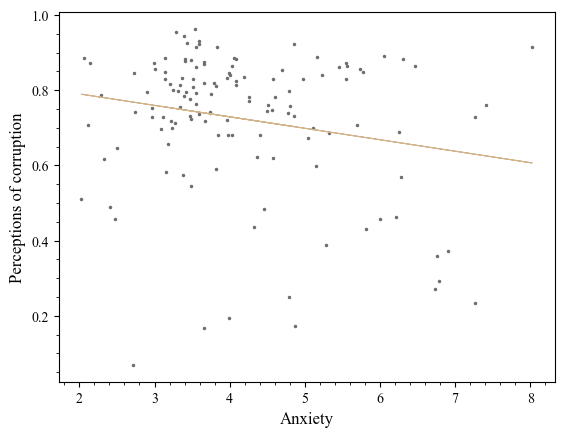

PA vs NA:
-------------------------------------------------
Pearson correlation: -0.33, p-value: 4.8218335566078205e-05
Spearman correlation: -0.25, p-value: 0.0022389613028794314
Kendall correlation: -0.17, p-value: 0.0024022497855637035
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


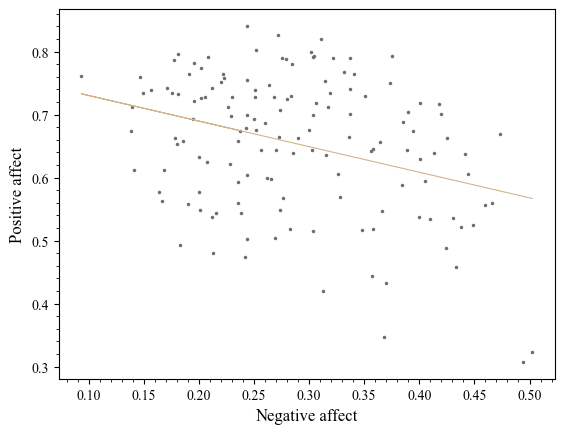

PA vs D:
-------------------------------------------------
Pearson correlation: -0.25, p-value: 0.0030429305237081507
Spearman correlation: -0.25, p-value: 0.0035508707895590937
Kendall correlation: -0.17, p-value: 0.0027733102635740647
Mutual information: 0.18, p-value: 5.00e-03
-------------------------------------------------


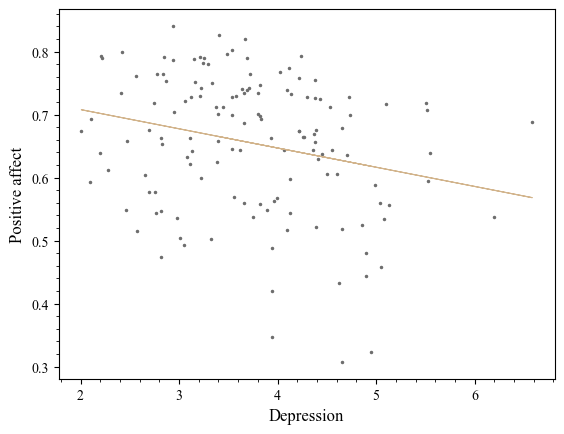

PA vs A:
-------------------------------------------------
Pearson correlation: 0.16, p-value: 0.06315139086102971
Spearman correlation: 0.25, p-value: 0.0030536513259657623
Kendall correlation: 0.16, p-value: 0.004632086562642642
Mutual information: 0.00, p-value: 1.00e+00
-------------------------------------------------


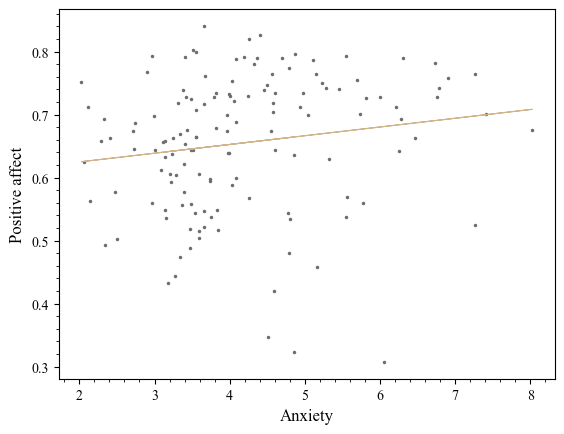

NA vs D:
-------------------------------------------------
Pearson correlation: 0.45, p-value: 2.1795891014669923e-08
Spearman correlation: 0.42, p-value: 2.558461950081242e-07
Kendall correlation: 0.29, p-value: 5.061184525702693e-07
Mutual information: 0.04, p-value: 2.45e-01
-------------------------------------------------


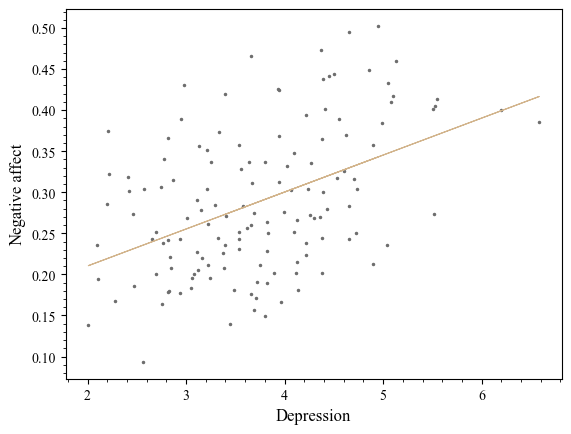

NA vs A:
-------------------------------------------------
Pearson correlation: 0.11, p-value: 0.18286108302244458
Spearman correlation: 0.15, p-value: 0.08802994173464362
Kendall correlation: 0.10, p-value: 0.07404357463915365
Mutual information: 0.08, p-value: 7.70e-02
-------------------------------------------------


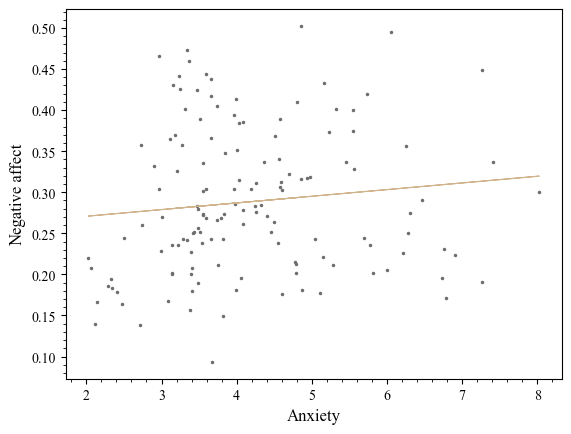

D vs A:
-------------------------------------------------
Pearson correlation: 0.14, p-value: 0.09396088609177673
Spearman correlation: 0.14, p-value: 0.0876702320925491
Kendall correlation: 0.10, p-value: 0.07627690286008393
Mutual information: 0.11, p-value: 3.00e-02
-------------------------------------------------


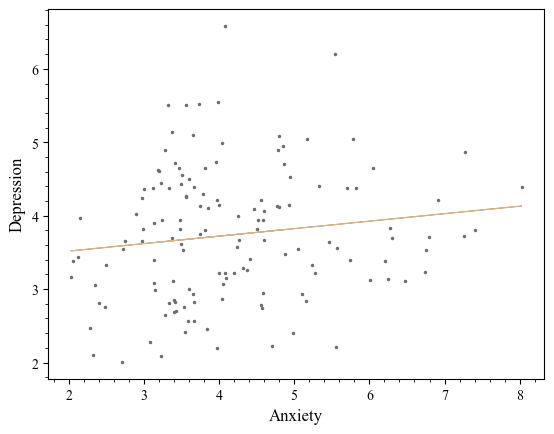

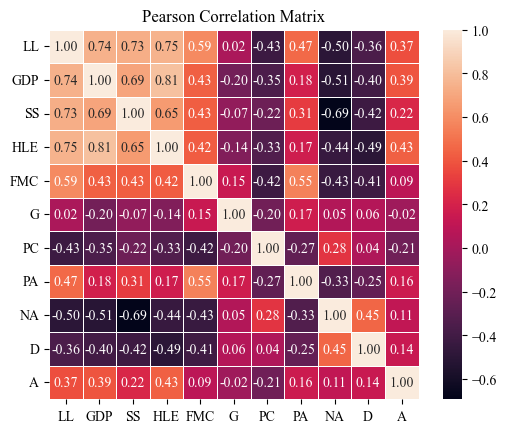

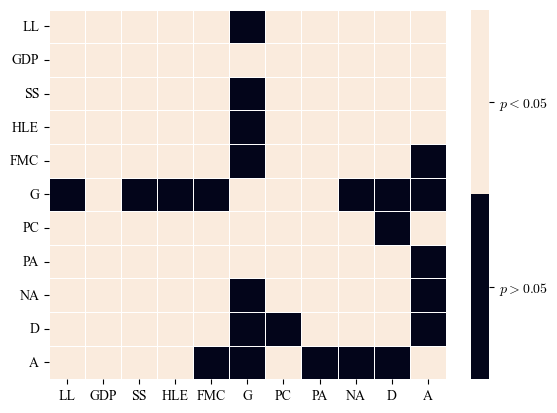

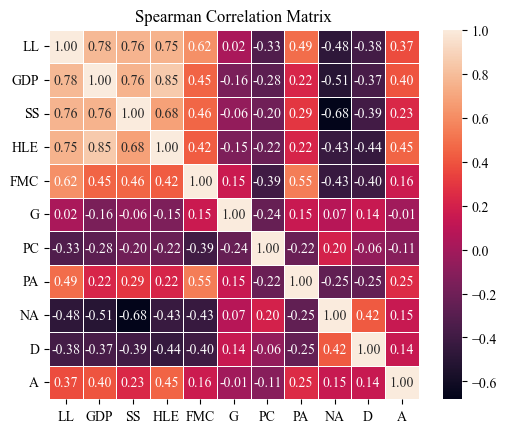

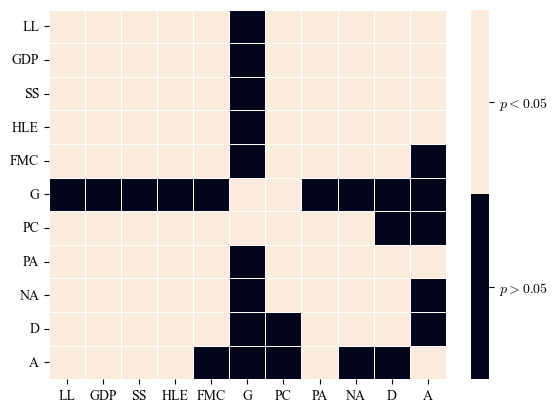

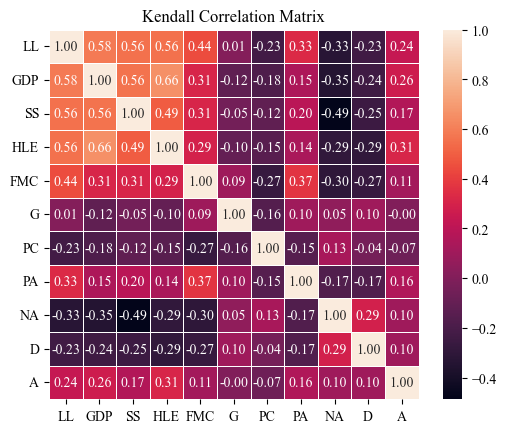

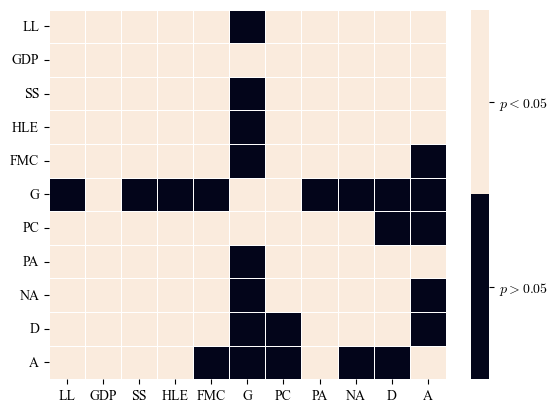

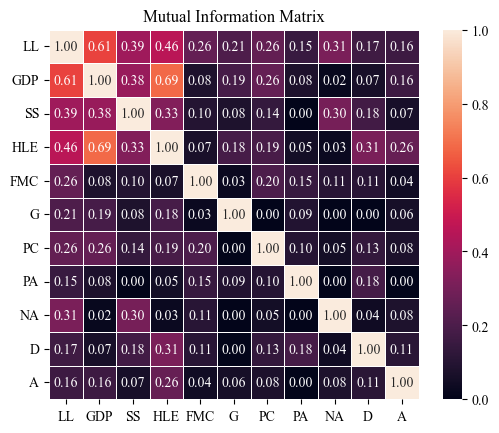

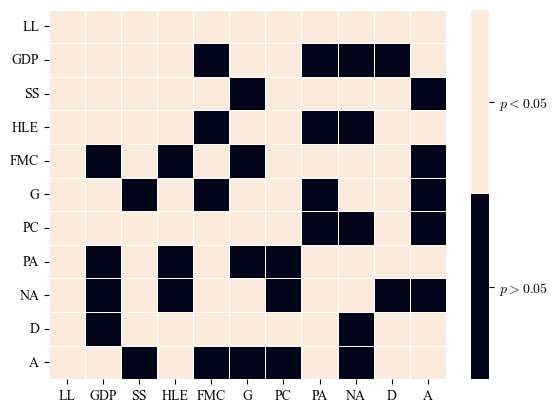

In [17]:
def correlations_per_year(df, year, variables, p_representation = "log", plotting=False, corr_mat = False, verbose=False, save=False):
    """
    Calculate various correlation matrices (Pearson, Spearman, Kendall, and Mutual Information) for specified variables within a given year.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        year (int): The year for which correlations are calculated.
        variables (list): List of variables for which correlations will be calculated.
        p_representation (str, optional): The representation to use for transforming the p-values in the hypothesis testing. It can be either "log" for logarithmic transformation or "binary" for binary transformation based on a significance threshold. Defaults to "log".
        plotting (bool, optional): Whether to plot scatter plots and correlation matrices. Defaults to False.
        corr_mat (bool, optional): Whether to compute and plot correlation matrices. Defaults to False.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.
        save (bool, optional): Whether to save the plots. Defaults to False.
    
    Returns:
        None
    """
    df = df[df["Year"] == year]
    length = len(variables)  # Number of specified variables
    
    p_matrix_pear = np.zeros((length, length), dtype=float)  # Pearson correlation matrix
    p_matrix_spear = np.zeros((length, length), dtype=float)  # Spearman correlation matrix
    p_matrix_kendall = np.zeros((length, length), dtype=float)  # Kendall correlation matrix
    p_matrix_minfo = np.zeros((length, length), dtype=float)  # Mutual information matrix

    for i in range(length):
        for j in range(i+1, length):
            # Get the subset of data for the two variables, removing any rows where either is NaN
            subset = df[[variables[i], variables[j]]].dropna()

            # Pearson correlation & linear regression
            slope, intercept, r_pear, p_pear, std_err = linregress(subset[variables[j]], subset[variables[i]])
            line = slope * subset[variables[j]] + intercept 
            p_matrix_pear[i, j] = hypothesis_testing(subset[variables[j]], subset[variables[i]], pearson_wrapper, method = "p-value")

            # Spearman correlation
            r_spear, p_spear = spearmanr(subset[variables[j]], subset[variables[i]])
            p_matrix_spear[i, j] = hypothesis_testing(subset[variables[j]], subset[variables[i]], spearman_wrapper, method = "p-value")
            
            # Kendall correlation
            r_kendall, p_kendall = kendalltau(subset[variables[j]], subset[variables[i]])
            p_matrix_kendall[i, j] = hypothesis_testing(subset[variables[j]], subset[variables[i]], kendall_wrapper, method = "p-value")

            # Mutual information
            mi= mutual_information(subset[variables[j]], subset[variables[i]])
            p_mi = hypothesis_testing(subset[variables[j]], subset[variables[i]], mutual_information, method = "p-value")
            p_matrix_minfo[i, j] = p_mi  

            if verbose:
                print(f"{variables[i]} vs {variables[j]}:")
                print("-------------------------------------------------")
                print(f"Pearson correlation: {r_pear:.2f}, p-value: {p_pear}")
                print(f"Spearman correlation: {r_spear:.2f}, p-value: {p_spear}")
                print(f"Kendall correlation: {r_kendall:.2f}, p-value: {p_kendall}")
                print(f"Mutual information: {mi:.2f}, p-value: {p_mi:.2e}")
                print("-------------------------------------------------")
            
            if plotting:
                # Legend text about correlations and p-values
                legend_pear = r"$r = {:.2f}, \ p_r = {:.2e}$".format(r_pear, p_pear)
                legend_spear = r"$\rho = {:.2f}, \ p_\rho = {:.2e}$".format(r_spear, p_spear)
                legend_kendall = r"$\tau = {:.2f}, \ p_\tau = {:.2e}$".format(r_kendall, p_kendall)
                legend_minfo = r"$I = {:.2f}, \ p_I = {:.2e}$".format(mi, p_mi)
                legend_text = legend_pear + "\n" + legend_spear + "\n" + legend_kendall + "\n" + legend_minfo
                fig, ax = plt.subplots()
                ax.scatter(subset[variables[j]], subset[variables[i]], label = legend_text, color = '#6E6E6E')
                ax.plot(subset[variables[j]], line, color='#D2B48C')
                ax.set_ylabel(acronyms_mapping[variables[i]])
                ax.set_xlabel(acronyms_mapping[variables[j]])
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                # ax.legend()
                if save: plt.savefig(f"Figures/{variables[i]}_vs_{variables[j]}_2019_scatter_plot.png", dpi = 300)
                plt.show()
                
    if corr_mat:
        # Prepare final matrices for plotting. Fill the lower triangle of the matrices
        pear_correlation_matrix = df[variables].corr(method="pearson")
        p_matrix_pear = hypothesis_testing_matrix_preparation(p_matrix_pear, p_representation= p_representation)    
        
        spear_correlation_matrix = df[variables].corr(method="spearman")
        p_matrix_spear = hypothesis_testing_matrix_preparation(p_matrix_spear, p_representation= p_representation)
        
        kendall_correlation_matrix = df[variables].corr(method="kendall")
        p_matrix_kendall = hypothesis_testing_matrix_preparation(p_matrix_kendall, p_representation= p_representation)
        
        mi_matrix = df[variables].corr(method=mutual_information) # Important note: .corr sets the diagonal to 1 and symmetrically fills the lower triangle
        mi_p_matrix = hypothesis_testing_matrix_preparation(p_matrix_minfo, p_representation= p_representation)

        # Plot Pearson correlation matrix heatmap
        fig, ax = plt.subplots()
        sns.heatmap(pear_correlation_matrix, annot=True, fmt=".2f", square=True, xticklabels=variables, yticklabels=variables, linewidths=0.7, ax = ax)
        ax.set_title("Pearson Correlation Matrix")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()

        hypothesis_testing_matrix_plot(p_matrix_pear, x_labels = variables, y_labels = variables, save = save, file_name = f"p_matrix_pearson_{year}_.png")
        
        # Plot Spearman correlation matrix heatmap
        fig, ax = plt.subplots()
        sns.heatmap(spear_correlation_matrix, annot=True, fmt=".2f", square=True, xticklabels=variables, yticklabels=variables, linewidths=0.7, ax = ax)
        ax.set_title("Spearman Correlation Matrix")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()

        hypothesis_testing_matrix_plot(p_matrix_spear, x_labels = variables, y_labels = variables, save = save, file_name = f"p_matrix_spearman_{year}_.png")
        
        # Plot Kendall correlation matrix heatmap
        fig, ax = plt.subplots()
        sns.heatmap(kendall_correlation_matrix, annot=True, fmt=".2f", square=True, xticklabels=variables, yticklabels=variables, linewidths=0.7, ax = ax)
        ax.set_title("Kendall Correlation Matrix")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()
        
        hypothesis_testing_matrix_plot(p_matrix_kendall, x_labels = variables, y_labels = variables, save = save, file_name = f"p_matrix_kendall_{year}_.png")
        
        # Plot Mutual information matrix heatmap
        fig, ax = plt.subplots()
        sns.heatmap(mi_matrix, annot=True, fmt=".2f", square=True, xticklabels=variables, yticklabels=variables, linewidths=0.7, ax = ax)
        ax.set_title("Mutual Information Matrix")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()
        
        hypothesis_testing_matrix_plot(mi_p_matrix, x_labels = variables, y_labels = variables, save = save, file_name = f"p_matrix_mutual_info_{year}_.png")

# Example usage
# variables = ['LL', 'GDP', 'G']  # Specify your variables here
correlations_per_year(df_full, 2019, variables, p_representation = "binary", plotting=True, corr_mat=True, verbose=True, save=False)

Given that the Kendall's Tau correlation is performing worse than the Pearson's correlation and the Spearman's correlation, we will only use the Pearson's correlation and the Spearman's correlation for the rest of the analysis. Pearson and Spearman both are more sensitive in different cases, therefore we keep them both. On the other hand, the Mutual Information is a non-parametric method that captures any kind of relationship between the variables, therefore we will use it as well.

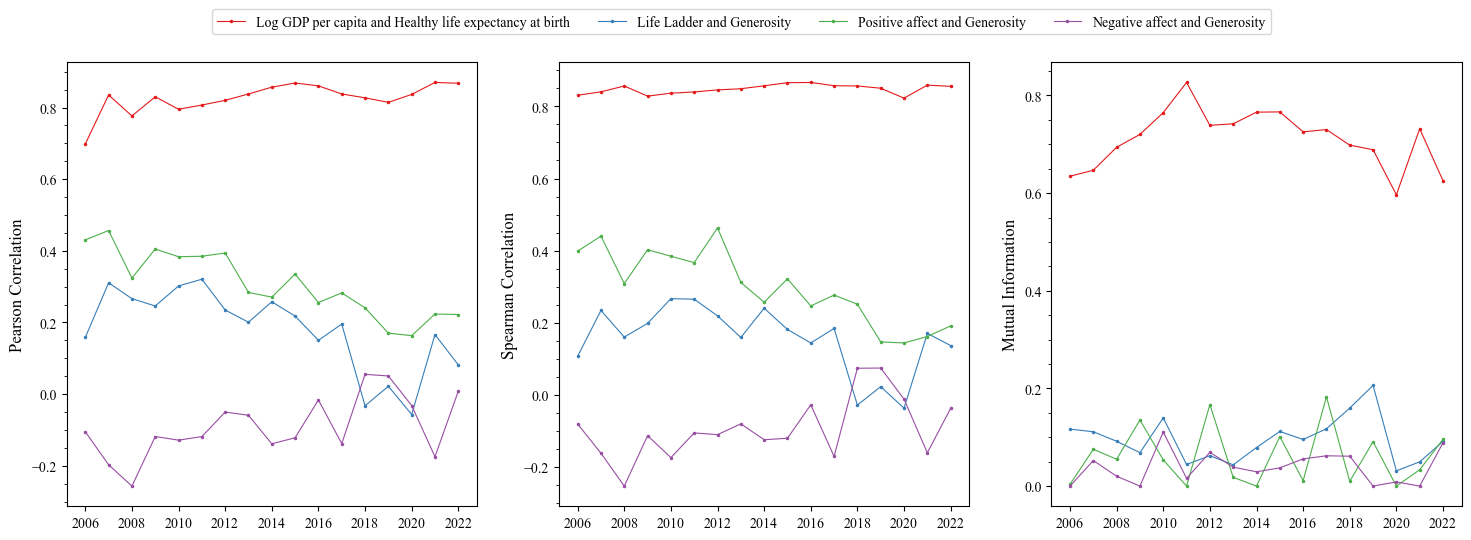

In [18]:
def plot_correlations_over_time_all_methods(df, variable_pairs, methods=['Pearson Correlation'], ncol = 4, save = False, filename = "Correlations_over_time_all_methods.png"):
    """
    Plot correlations over time for specified variable pairs using different methods such as Pearson Correlation, Spearman Correlation, and Mutual Information.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        variable_pairs (list of tuples): List of variable pairs for which correlations will be plotted.
        methods (list of str, optional): List of methods for correlation calculation. Defaults to ['Pearson Correlation'].
        ncol (int, optional): Number of columns for the legend. Defaults to 4.
        save (bool, optional): Whether to save the plot. Defaults to False.
        filename (str, optional): Name of the file to save the plot. Defaults to "Correlations_over_time_all_methods.png".

    Returns:
        None
    """
    # Initial setup
    years = np.sort(df['Year'].unique())[1:]
    fig, axes = plt.subplots(1, len(methods), figsize=(6 * len(methods), 6))  # Adjust figure size based on the number of methods
    if len(methods) == 1:  # If there's only one method, ensure axes is iterable
        axes = [axes]
    plt.subplots_adjust(top=0.85)  # Adjusting space for the legend
    correlation_data = {method: {pair: [] for pair in variable_pairs} for method in methods}

    # Calculate correlations for each year and method
    for year in years:
        df_year = df[df['Year'] == year].drop(columns=["Year", "Country"])
        for method in methods:
            if method == "Pearson Correlation": corr_matrix = df_year.corr(method='pearson')
            elif method == "Spearman Correlation": corr_matrix = df_year.corr(method='spearman')
            elif method == "Mutual Information": corr_matrix = df_year.corr(method=mutual_information)  # Adjusted to call mutual_information
            
            for pair in variable_pairs:
                correlation_data[method][pair].append(corr_matrix.at[pair[0], pair[1]])
    
    # Plotting
    colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#A9A9A9', '#A65628', '#F781BF', '#999999']
    for i, method in enumerate(methods):
        for j, (pair, correlations) in enumerate(correlation_data[method].items()):
            axes[i].plot(years, correlations, marker='o', label=f'{acronyms_mapping[pair[0]]} and {acronyms_mapping[pair[1]]}', color=colors[j])
        
        axes[i].set_ylabel(method)
        axes[i].yaxis.set_minor_locator(AutoMinorLocator()) 
        
    # Shared Legend and Labels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=ncol)
    if save: plt.savefig(f"Figures/{filename}", dpi=300)
    
    plt.show()

claim1_pairs = [
    ("GDP", "HLE"), 
    ("LL", "G"), 
    ("PA", "G"), 
    ("NA", "G")
    ]
filename1 = "Correlations_over_time_claim1.png"

claim2_H_pairs = [
    ('LL', 'SS'),
    # ('LL', 'GDP'),
    ('LL', 'HLE'),
    ('LL', 'FMC'),
    # ('LL', 'G'),
    ('LL', 'PC'),
    ('LL', 'PA'),
    ('LL', 'NA'),
    ('LL', 'D'),
    ('LL', 'A')
    ]
filename2 = "Correlations_over_time_claim2_H.png"

claim2_PA_pairs = [
    # ('PA', 'GDP')
    ('PA', 'SS'),
    ('PA', 'HLE'),
    ('PA', 'FMC'),
    # ('PA', 'G')
    ('PA', 'PC'),
    ('PA', 'NA'),
    ('PA', 'D'),
    ('PA', 'A')
    ]
filename3 = "Correlations_over_time_claim2_PA.png"

claim2_NA_pairs = [
    # ('NA', 'GDP')
    ('NA', 'SS'),
    ('NA', 'HLE'),
    ('NA', 'FMC'),
    # ('NA', 'G')
    ('NA', 'PC'),
    ('NA', 'D'),
    ('NA', 'A')
  ]
filename4 = "Correlations_over_time_claim2_NA.png"


others = [
    ('LL', 'GDP'), 
    ('PA', 'GDP'), 
    ('NA', 'GDP')
    ]
filename5 = "Correlations_over_time_others.png"

# Reusing the same variable pairs for plotting    
methods = ['Pearson Correlation', 'Spearman Correlation', 'Mutual Information']

plot_correlations_over_time_all_methods(df_full, claim1_pairs, methods=methods, save = False, filename = filename1)
# plot_correlations_over_time_all_methods(df_full, claim2_H_pairs, methods=methods, save = False, filename = filename2)
# plot_correlations_over_time_all_methods(df_full, claim2_PA_pairs, methods=methods, save = False, filename = filename3)
# plot_correlations_over_time_all_methods(df_full, claim2_NA_pairs, methods=methods, save = False, filename = filename4, ncol=3)
# plot_correlations_over_time_all_methods(df_full, others, methods=methods, save = False, filename = filename5)

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


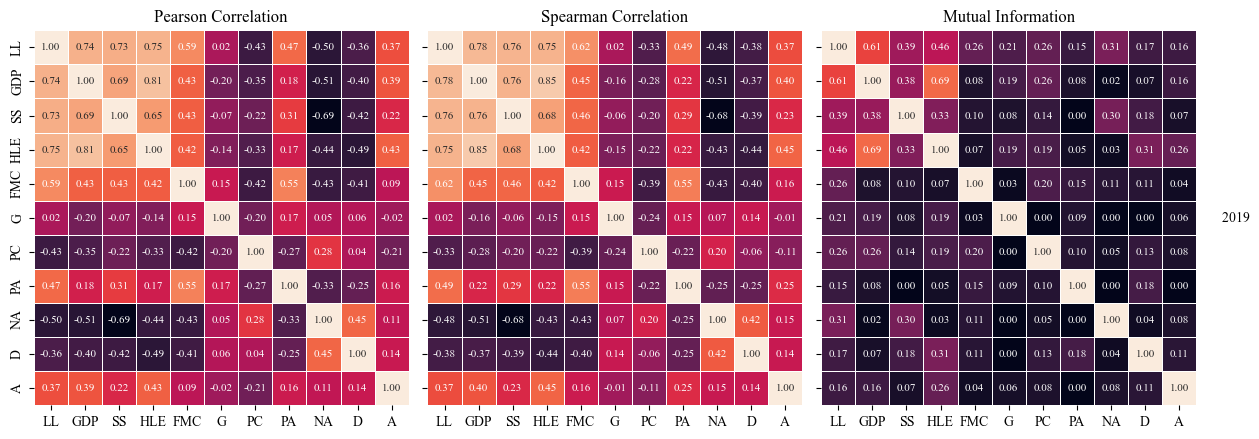

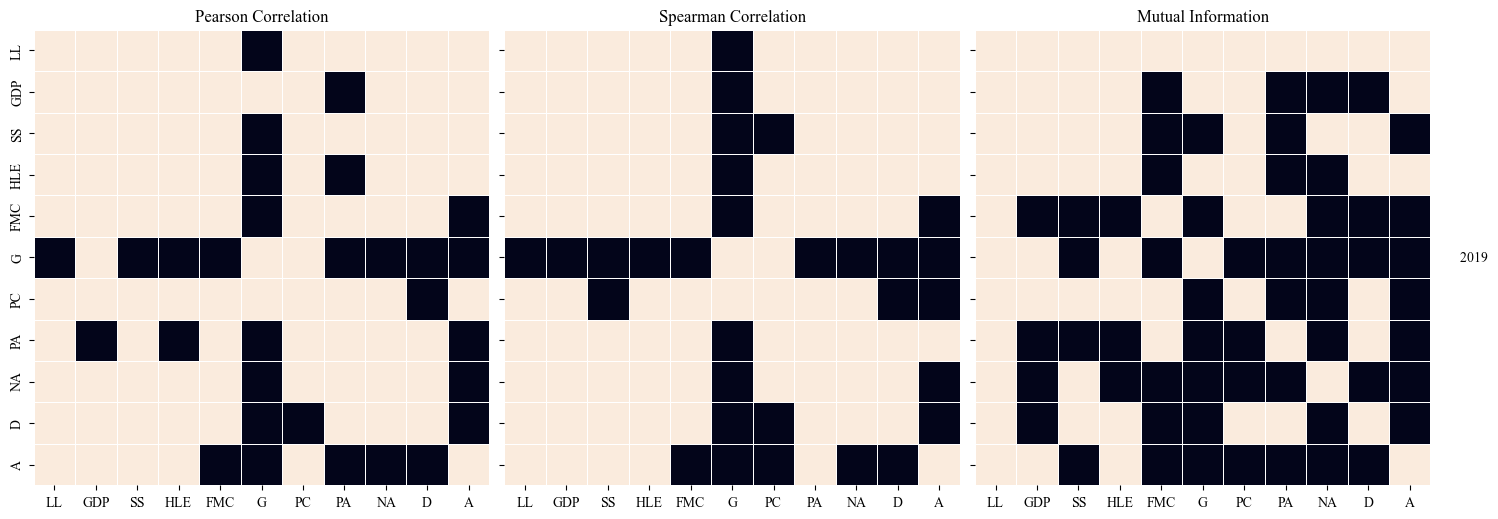

In [25]:
def matrices_over_time(df, years, variables, save=False, filename = "Correlation_matrices_over_time.png"):
    """
    Generates correlation matrices and corresponding p-value matrices over time for specified years and variables, utilizing different methods such as Pearson Correlation, Spearman Correlation, and Mutual Information.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        years (list of int): List of years for which correlation matrices will be generated.
        variables (list of str): List of variables for which correlation matrices will be generated.
        save (bool, optional): Whether to save the generated plots. Defaults to False.
        filename (str, optional): Name of the file to save the plots. Defaults to "Correlation_matrices_over_time.png".

    Returns:
        None
    """
    methods = {
        "Pearson Correlation": pearson_wrapper,
        "Spearman Correlation": spearman_wrapper,
        "Mutual Information": mutual_information
    }

    # Set a smaller font size for annotations
    annot_kws = {"size": 8}

    # Adjust figsize or these parameters if the text still appears too tight
    fig_corr, axs_corr = plt.subplots(len(years), len(methods), sharex=True, sharey=True, figsize=(len(methods) * 5, len(years) * 5))
    fig_p, axs_p = plt.subplots(len(years), len(methods), sharex=True, sharey=True, figsize=(len(methods) * 5, len(years) * 5))
    
    if len(years) == 1 or len(methods) == 1:
        axs_corr = axs_corr.reshape(len(years), len(methods))
        axs_p = axs_p.reshape(len(years), len(methods))
    
    for i, year in enumerate(tqdm(years)):
        df_year = df[df['Year'] == year].drop(columns=["Year", "Country"])
        df_year = df_year[variables]  # Only the selected variables
        for j, (name, method) in enumerate(methods.items()):
            corr_mat_file = f"Calculations/corr_mat_{year}_{name}.npy"
            p_mat_file = f"Calculations/p_mat_{year}_{name}.npy"

            if os.path.exists(corr_mat_file) and os.path.exists(p_mat_file):
                corr_mat = np.load(corr_mat_file)
                prepared_p_mat = np.load(p_mat_file)
            else:
                corr_mat, p_mat = method(df_year, variables) 
                prepared_p_mat = hypothesis_testing_matrix_preparation(p_mat, p_representation="binary")

                np.save(corr_mat_file, corr_mat)
                np.save(p_mat_file, prepared_p_mat)
        
            sns.heatmap(corr_mat, ax=axs_corr[i, j], annot=True, fmt=".2f", square=True, annot_kws=annot_kws, xticklabels=variables, yticklabels=variables, cbar=False, linewidths=0.7)
            axs_corr[0, j].set_title(f'{name}')
            
            sns.heatmap(prepared_p_mat, ax=axs_p[i, j], annot=False, square=True, xticklabels=variables, yticklabels=variables, vmin=0, vmax=1, cbar=False, linewidths=0.7)
            axs_p[0, j].set_title(f"{name}")

            if j == len(methods) - 1:  # Last column, add year annotation to the right
                axs_corr[i, j].text(1.05, 0.5, f"  {year}", transform=axs_corr[i, j].transAxes, verticalalignment='center', horizontalalignment='left')
                axs_p[i, j].text(1.05, 0.5, f"  {year}", transform=axs_p[i, j].transAxes, verticalalignment='center', horizontalalignment='left')
    
    # Adjust layout spacing for both figures
    fig_corr.subplots_adjust(wspace=0.05, hspace=0.5)
    fig_p.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.tight_layout()
    if save:
        fig_corr.savefig(f"Figures/Correlation_matrices_over_time_{filename}.png", dpi=300)
        fig_p.savefig(f"Figures/P-value_matrices_over_time_{filename}.png", dpi=300)
    plt.show()

years_with_full_data = np.sort(df_full['Year'].unique())[1:15] # Exclude 2005 and 2020-2022 due to missing data
# matrices_over_time(df_full, years_with_full_data, variables, save = True, filename = "all")
matrices_over_time(df_full, [2019], variables, save = False, filename = "2019")

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


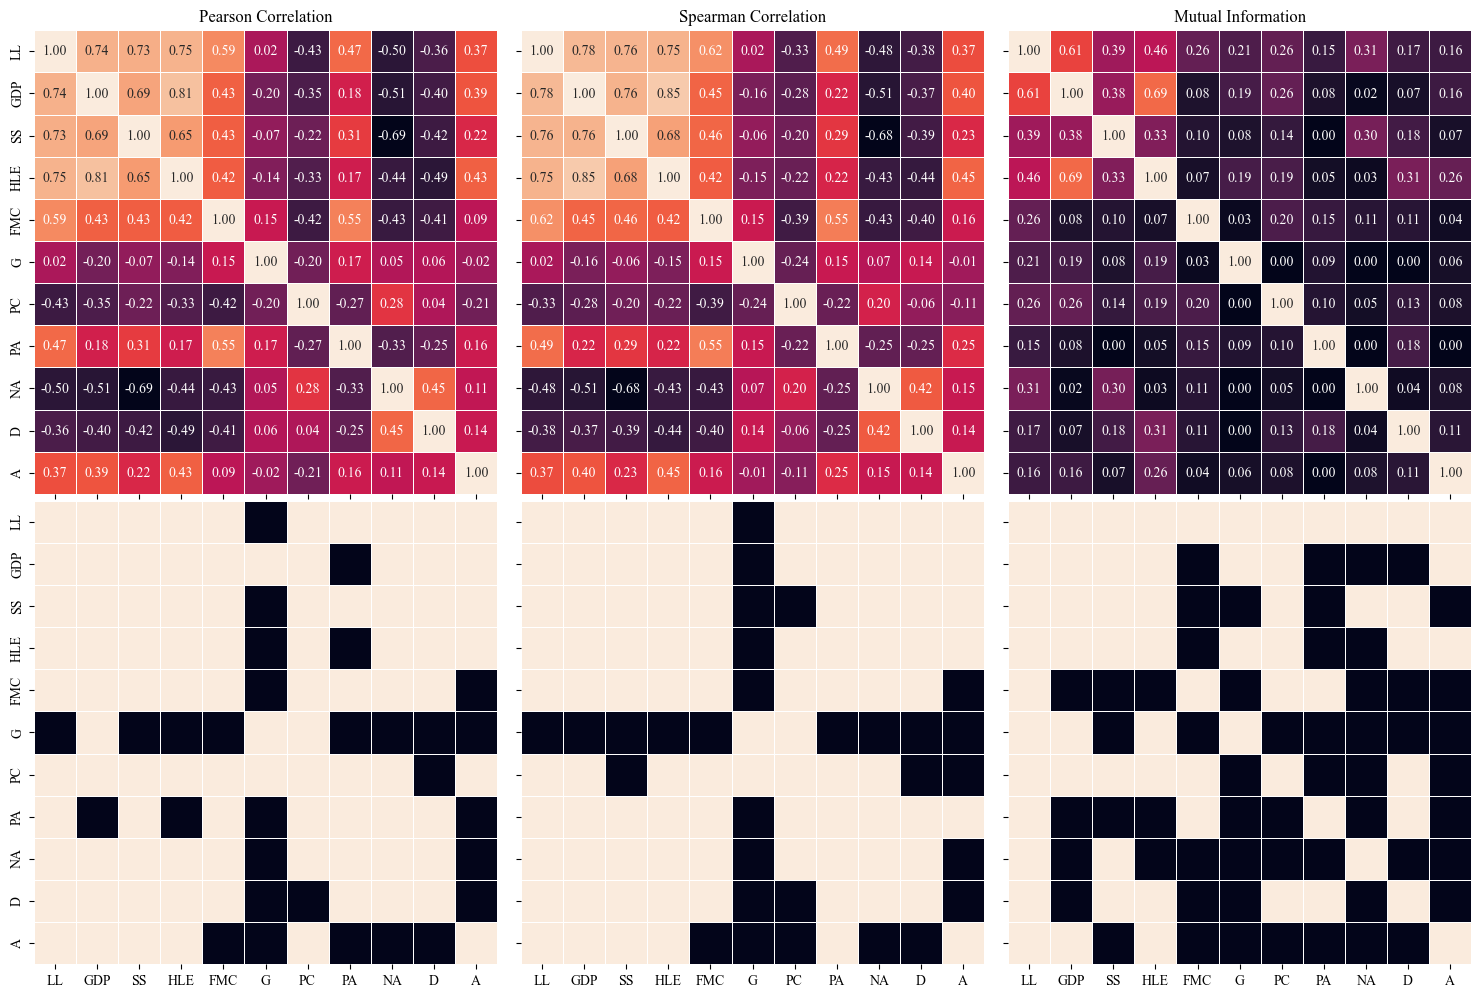

In [26]:
def plot_year_correlation_and_pvalues(df, year, variables, save=False, filename="Correlation_and_Pvalues"):
    """
    Plots correlation matrices and corresponding p-value matrices for a specified year and variables, using methods such as Pearson Correlation, Spearman Correlation, and Mutual Information.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        year (int): The year for which correlation matrices will be generated.
        variables (list of str): List of variables for which correlation matrices will be generated.
        save (bool, optional): Whether to save the generated plots. Defaults to False.
        filename (str, optional): Name of the file to save the plots. Defaults to "Correlation_and_Pvalues".

    Returns:
        None
    """
    methods = {
        "Pearson Correlation": pearson_wrapper,
        "Spearman Correlation": spearman_wrapper,
        "Mutual Information": mutual_information
    }

    # Create the figure and axes for the subplots
    fig, axs = plt.subplots(2, len(methods), sharex=True, sharey=True, figsize=(len(methods) * 5, 10))

    # Ensure we have a 2D array of axes even if there's only one method
    if len(methods) == 1:
        axs = np.array([axs])

    # Select the data for the specified year and the given variables
    df_year = df[df['Year'] == year].drop(columns=["Year", "Country"])
    df_year = df_year[variables]

    for j, (name, method) in enumerate(tqdm(methods.items())):
        corr_mat_file = f"Calculations/corr_mat_{year}_{name}.npy"
        p_mat_file = f"Calculations/p_mat_{year}_{name}.npy"

        if os.path.exists(corr_mat_file) and os.path.exists(p_mat_file):
            corr_mat = np.load(corr_mat_file)
            prepared_p_mat = np.load(p_mat_file)
        else:
            corr_mat = df_year.corr(method=method)
            p_mat = hypothesis_testing_matrix(df_year, variables, method)
            prepared_p_mat = hypothesis_testing_matrix_preparation(p_mat, p_representation="binary")

            # Save the newly calculated matrices
            np.save(corr_mat_file, corr_mat)
            np.save(p_mat_file, prepared_p_mat)

        # Create the heatmap for the correlation matrix
        sns.heatmap(corr_mat, ax=axs[0, j], annot=True, fmt=".2f", square=True, xticklabels=variables, yticklabels=variables, cbar=False, linewidths=0.7)
        axs[0, j].set_title(f'{name}')

        # Create the heatmap for the p-values matrix
        sns.heatmap(prepared_p_mat, ax=axs[1, j], annot=False, square=True, xticklabels=variables, yticklabels=variables, 
                    vmin=0, vmax=1, cbar=False, linewidths=0.7)

    # Adjust layout spacing for the figure
    # fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.tight_layout()

    # Save the figure if requested
    if save:
        fig.savefig(f"Figures/{filename}_{year}.png", dpi=300)

    plt.show()


plot_year_correlation_and_pvalues(df_full, 2019, variables, save=True)

# for y in years_with_full_data:
#     print(f"Year: {y}")
#     plot_year_correlation_and_pvalues(df_full, y, variables, save=True)

# 2. Time Series Analysis

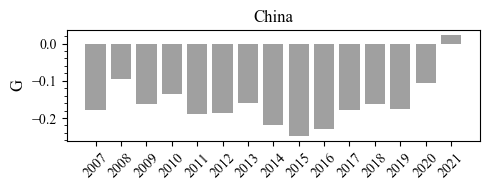

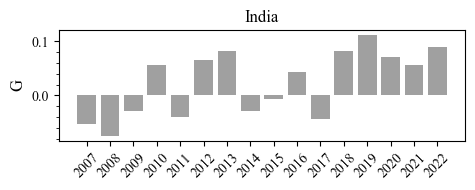

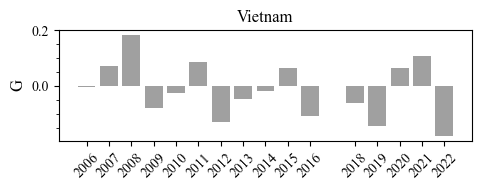

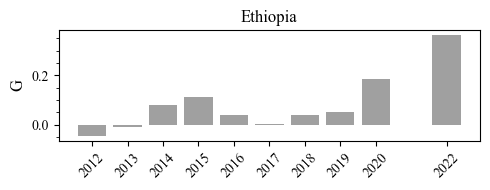

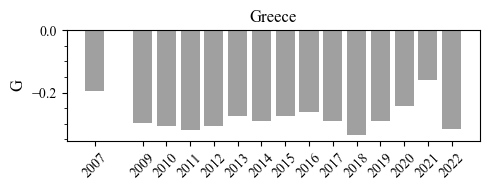

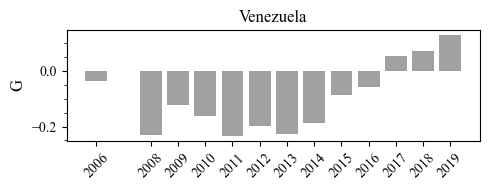

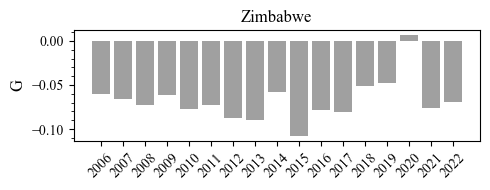

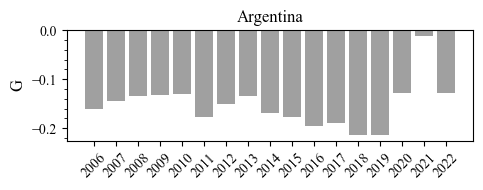

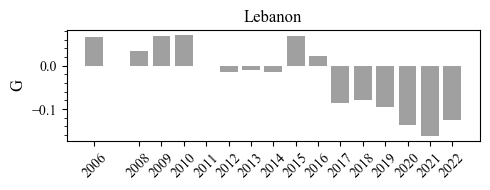

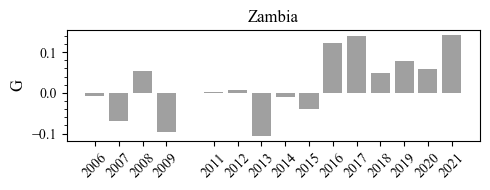

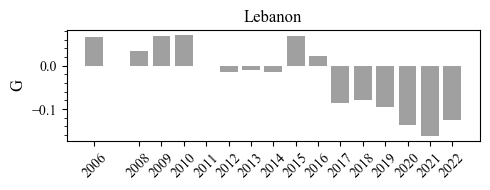

In [27]:
def time_series(df, countries, variables, ACF=False, max_lags=7, save=False, filename="Time_series_bar_plot.png"):
    """
    Plots time series bar plots for specified countries and variables, optionally including the Autocorrelation Function (ACF) plots.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        countries (list of str): List of countries for which time series will be plotted.
        variables (list of str): List of variables for which time series will be plotted.
        ACF (bool, optional): Whether to include Autocorrelation Function (ACF) plots. Defaults to False.
        max_lags (int, optional): Maximum number of lags to consider for ACF plots. Defaults to 7.
        save (bool, optional): Whether to save the generated plots. Defaults to False.
        filename (str, optional): Name of the file to save the plots. Defaults to "Time_series_bar_plot.png".

    Returns:
        None
    """
    # Determine the number of columns based on the ACF flag
    num_cols = 2 if ACF else 1
        
    for country in countries:
        # Extract data for the current country
        country_df = df[df['Country'] == country]
        
        # Create a figure and a set of subplots with GridSpec
        fig = plt.figure(figsize=(5, 2 * len(variables)))
        gridspec = GridSpec(len(variables), num_cols, width_ratios=[3, 1] if ACF else [3])
        
        # Create subplots for each variable
        for i, variable in enumerate(variables):
            # Extract data for the current country and variable, avoiding NaNs
            valid_data = country_df.dropna(subset=[variable])

            # Create the time series subplot
            ax_time_series = fig.add_subplot(gridspec[i, 0])
            ax_time_series.bar(valid_data['Year'], valid_data[variable], alpha=0.75, color='gray')
            ax_time_series.set_ylabel(variable)
            # ax_time_series.set_ylabel(acronyms_mapping[variable])
            ax_time_series.set_xticks(valid_data['Year'])
            ax_time_series.set_xticklabels(valid_data['Year'], rotation=45)
            ax_time_series.yaxis.set_minor_locator(AutoMinorLocator())

            if i == 0:
                ax_time_series.set_title(country)
            
            # Create the ACF subplot if the ACF flag is True
            if ACF:
                ax_acf = fig.add_subplot(gridspec[i, 1])
                plot_acf(valid_data[variable], ax=ax_acf, lags = max_lags)
                ax_acf.set_ylim(-1.05, 1.08)
                ax_acf.set_title('ACF')
                ax_acf.xaxis.set_minor_locator(AutoMinorLocator())
                
            # Only the last row should have the x-axis labels visible
            if i < len(variables) - 1:
                ax_time_series.set_xticklabels([])
                if ACF:
                    ax_acf.set_xticklabels([])

        plt.tight_layout()
        if save: fig.savefig(f"Figures/{filename}_{country}_{variables}.png", dpi=300)
        plt.show()
        
# Example usage, assuming 'df' is your DataFrame loaded from the file
all_countries = df_full['Country'].unique()
countries = [
    'Denmark', # pretty stable Lacks 2006
    'Spain', # Spain
    'Argentina', # Little fluctuation lacks 2005
    'China', # Lacks 2005 & 2022
    'Ghana', # Cool fluctuations lacks 2005
    'Cambodia', # Cool fluctuation lacks 2005
    'Egypt', # Cool fluctuations lacks 2006
    'Zimbabwe', # Cool fluctuations. Lacks 2005
    'Lebanon', # super big drop last years. Lacks 2007
    'Afghanistan', # Saddest although lacks 2005-2007 & 2020
]

countries_with_high_GDP_variability = [
    # High increases in economy
    'China', 
    # 'Hong Kong S.A.R. of China', # not HLE data
    'India', 
    'Vietnam',
    'Ethiopia',
    # 'Qatar', # not enough data
    # High fluctuations or decreases in economy
    'Greece', 
    'Venezuela',
    'Zimbabwe',  
    'Argentina',
    'Lebanon',
    'Zambia',
    'Lebanon'
]
vars_claim1 = ['GDP', 'HLE', 'G']
GDP_and_HLE = ['GDP', 'HLE']
varG = ['G']
vars_wellbeing = ['LL', 'PA', 'NA']
vars_claim2 = ['LL', 'SS', 'HLE', 'FMC', 'PC', 'PA', 'NA', 'D', 'A']

# time_series(df_full, countries_with_high_GDP_variability, GDP_and_HLE, save = False, filename="Time_series_bar_plot")
# time_series(df_full, countries_with_high_GDP_variability, varG, save = False, filename = "Time_series_bar_plot")
# time_series(df_full, countries, vars_wellbeing, save = False, filename="Time_series_bar_plot")
# time_series(df_full, countries, vars_claim2, save = False, filename="Time_series_bar_plot")

In [29]:
CCF0 = lambda x, y: sm.tsa.stattools.ccf(x, y, adjusted=True, fft=False)[0]

def CCF_analysis(df, countries, variables, corr_matrix=True, max_lag=7):
    """
    Performs Cross-Correlation Function (CCF) analysis for specified countries and variables, optionally including correlation matrix and z-score matrix.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        countries (list of str): List of countries for which CCF analysis will be performed.
        variables (list of str): List of variables for which CCF analysis will be performed.
        corr_matrix (bool, optional): Whether to include correlation matrix and z-score matrix. Defaults to True.
        method (str, optional): The method used for hypothesis testing. It can be either 'Pearson Correlation' (default), 'Spearman Correlation', or 'Mutual Information'.
        max_lag (int, optional): Maximum number of lags to consider in the CCF analysis. Defaults to 7.

    Returns:
        None
    """
    for country in countries:
        country_df = df[df['Country'] == country] # Extract data for the current country
        
        CCF_matrix = np.zeros((len(variables), len(variables))) # Initialize the CCF matrix
        z_scores = np.zeros((len(variables), len(variables))) # Initialize the z-score matrix   
        
        for i, var_i in enumerate(variables):
            fig, axs = plt.subplots(len(variables), 1, sharex=True, figsize=(5, 3 * len(variables)))
            if len(variables) == 1: axs = [axs]  

            for j, var_j in enumerate(variables):
                valid_data = country_df.dropna(subset=[var_i, var_j]) # Drop NaN only affecting these two columns
                
                CCF = sm.tsa.stattools.ccf(valid_data[var_i], valid_data[var_j], adjusted=True, fft=False)[:max_lag + 1]
                
                CCF_matrix[i, j] = CCF[0]
                
                z_score = hypothesis_testing(valid_data[var_i], valid_data[var_j], CCF0, method = "z-score")
                z_scores[i, j] = z_score

                # Plot the CCF for each variable pair
                lags = np.arange(0, max_lag + 1)
                axs[j].scatter(lags, CCF, label=f'{var_i} & {var_j}')
                axs[j].set_ylabel("CCF")
                axs[j].yaxis.set_minor_locator(AutoMinorLocator())
                axs[j].legend()

            axs[0].set_title(f"{country}")
            axs[-1].set_xlabel("Lag")
            axs[-1].xaxis.set_minor_locator(AutoMinorLocator())
            plt.tight_layout()
            plt.show()

        if corr_matrix:
            plt.figure(figsize=(8, 6))
            sns.heatmap(CCF_matrix, annot=True, xticklabels=variables, yticklabels=variables, fmt=".2f")
            plt.title(f"CCF Matrix for {country}")
            plt.show()
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(z_scores, annot=True, xticklabels=variables, yticklabels=variables, fmt=".2f")
            plt.title(f"Z-Score Matrix for {country}")
            plt.show()

countries = [
    'Denmark', # pretty stable Lacks 2006
    'Spain', # Spain
    'Argentina', # Little fluctuation lacks 2005
    'China', # Lacks 2005 & 2022
    'Ghana', # Cool fluctuations lacks 2005
    'Cambodia', # Cool fluctuation lacks 2005
    'Egypt', # Cool fluctuations lacks 2006
    'Zimbabwe', # Cool fluctuations. Lacks 2005
    'Lebanon', # super big drop last years. Lacks 2007
    'Afghanistan', # Saddest although lacks 2005-2007 & 2020
]

variables = [
    # "LL",  # Measure of overall life satisfaction
    "GDP",  # Logarithm of GDP per capita, indicating economic prosperity
    # "SS",  # The presence of support from friends, family, or social network
    "HLE",  # Expected number of years of healthy life at birth
    # "FMC",  # The perceived amount of personal freedom
    "G",  # Measure of altruistic behavior in the population
    # "PC",  # The level of corruption as perceived by the public
    # "PA",  # Measure of the average level of positive emotions experienced
    # "NA",  # Measure of the average level of negative emotions experienced
    # "D",  # Prevalence or severity of depressive symptoms in the population
    # "A"  # Prevalence or severity of anxiety symptoms in the population
]

# CCF_analysis(df_full, countries_with_high_GDP_variability, variables, corr_matrix=True)     
# CCF_analysis(df_full, countries, variables, corr_matrix=True)     

# 3. Clustering

In [31]:
def plot_dendrogram(df, variables, year = 2019, method = 'Pearson Correlation', clust_method = 'weighted', plotting = True, save = False, filename = "Dendrogram.png"):
    """
    Plots a dendrogram based on the correlation matrix of the specified variables for a given year.

    Args:
        df (pandas.DataFrame): The DataFrame containing data.
        variables (list of str): List of variables for which the dendrogram will be plotted.
        year (int, optional): The year for which the dendrogram will be plotted. Defaults to 2019.
        method (str, optional): The method used to calculate correlations. It can be 'Pearson Correlation' (default), 'Spearman Correlation', or 'Mutual Information'.
        clust_method (str, optional): The clustering method. Defaults to 'weighted'.
        plotting (bool, optional): Whether to plot the dendrogram. Defaults to True.
        save (bool, optional): Whether to save the plot as an image. Defaults to False.
        filename (str, optional): The filename to use when saving the plot. Defaults to "Dendrogram.png".

    Returns:
        float: The Cophenetic Correlation Coefficient.
    """
    df_year = df[df['Year'] == year][variables]
    if method == "Pearson Correlation": corr_matrix = df_year.corr(method='pearson')
    elif method == "Spearman Correlation": corr_matrix = df_year.corr(method='spearman')
    elif method == "Mutual Information": corr_matrix = df_year.corr(method=mutual_information)
    else: return "You must choose a method between 'Pearson Correlation', 'Spearman Correlation' and 'Mutual Information'"

    dist_array = squareform(1 - abs(corr_matrix.values))    
    linkage_matrix = linkage(dist_array, method = clust_method, optimal_ordering = True)
    
    coph_corr, _ = cophenet(linkage_matrix, dist_array)
    print(f"Cophenetic Correlation Coefficient: {coph_corr}")
    
    # Plotting
    if plotting:
        fig, ax = plt.subplots(figsize=(10, 8))
        dendrogram(linkage_matrix, labels=corr_matrix.columns, ax=ax)
        ax.set_title(f"Dendrogram for Year {year} ({method})")
        ax.set_ylabel('Distance')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        if save: plt.savefig(filename, dpi=300)
        plt.show()
    return coph_corr

variables = [
    "LL",  
    "GDP", 
    "SS",  
    "HLE", 
    "FMC", 
    "G",  
    "PC", 
    "PA", 
    "NA", 
    "D",  
    "A"  
]

# High cophenetic correlation coefficient. Order of preference:
clust_method = 'weighted' 
# clust_method = 'centroid' 
# clust_method = 'average' 
# clust_method = 'median'

# Low cophenetic correlation coefficient
# clust_method = 'single' # Good
# clust_method = 'complete' # Separation that I don't like
# clust_method = 'ward' # Separation that I don't like

# plot_dendrogram(df_full, variables, year = 2019, method = 'Pearson Correlation', clust_method = clust_method, save = False, filename = f"Figures/Dendrogram_2019_Pearson.png")
# plot_dendrogram(df_full, variables, year = 2019, method = 'Spearman Correlation', clust_method = clust_method, save = False, filename = f"Figures/Dendrogram_2019_Spearman.png")
# plot_dendrogram(df_full, variables, year = 2019, method = 'Mutual Information', clust_method = clust_method, save = False, filename = f"Figures/Dendrogram_2019_mi.png")
    

# for year in range(2006, 2020):
#     print(f"Year: {year}")
#     print("-----------------------------------")
#     plot_dendrogram(df_full, variables, year = year, method = 'Pearson Correlation', clust_method = clust_method, save = True, filename = f"Figures/Dendrogram_{year}_Pearson.png")
#     plot_dendrogram(df_full, variables, year = year, method = 'Spearman Correlation', clust_method = clust_method, save = True, filename = f"Figures/Dendrogram_{year}_Spearman.png")
#     plot_dendrogram(df_full, variables, year = year, method = 'Mutual Information', clust_method = clust_method, save = True, filename = f"Figures/Dendrogram_{year}_mi.png")

# For all methods 'average', 'weighted', 'centroid', 'median' wins. Then 'single', 'complete' and finally 'ward' is the worst.